# Create land surface dataset for CLM6
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Overall goal: create land surface properties for exposed shelves and add ice sheets according to ICE-6G
- Tools used
  - [mksurfdata_esmf](https://github.com/ESCOMP/CTSM/tree/master/tools/mksurfdata_esmf)
  - [f90nml](https://github.com/marshallward/f90nml)
- Use large memory (I used a node on Derecho)
- References
  - [CTSM Tech Note](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/index.html)

In [1]:
import subprocess
import datetime
import copy
import f90nml
import re
from pathlib import Path

import numpy as np
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt

---
## Input
- The namelist file for the preindustrial case (using potential vegetation and without urban, etc.)
  - If it doesn't exist, you can generate it with `gen_mksurfdata_namelist`
- The LGM land fraction and glacier coverage from ICE-6G & GMTED2010
  - The "high resolution" land fraction file is an output when generating CAM7 topo file
  - Pad variables in longitude direction for interpolation

In [2]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf'

250210


In [3]:
pre_nml = f"{work_dir}/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c240919.namelist"

In [4]:
file_lgm_landf = '/glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/gmted2010_modis_bedmachine-rawdata-220518_21ka_20240520.nc'

In [5]:
ice6g_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/ice6g_10min'
ice6g_pre_fname = 'I6_C.VM5a_10min.0.nc'
ice6g_lgm_fname = 'I6_C.VM5a_10min.21.nc'

---
## Output
- `fsurdat_out` and `fsurdat_log`
- LGM namelist is the key
- We will create many raw files for the LGM land surface properties along the way

In [6]:
lgm_nml = f"{work_dir}/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c{today}.namelist"

fsurdat_out = f"{work_dir}/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c{today}.nc"
fsurdat_log = f"{work_dir}/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c{today}.log"

# The fsurdat_out above used preindustrial topography stats (SLOPE & STD_ELEV)
# I used simple extrapolation to get those variables for the exposed LGM shelves.
fsurdat_out_topostats = f"{work_dir}/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_topostats_c{today}.nc"

In [7]:
nml = f90nml.read(pre_nml)
nml_dict = nml.todict()

lgm_nml_dict = copy.deepcopy(nml_dict)
lgm_nml_dict['mksurfdata_input']['fsurdat'] = fsurdat_out
lgm_nml_dict['mksurfdata_input']['fsurlog'] = fsurdat_log

---
## Executable and tools

In [8]:
mksurfdata_exe = f"{work_dir}/tool_bld/mksurfdata"

- Function to fill nans with nearest neighbor
- Use n_points = 1 for better results (use 100 for quick test)

In [9]:
def fill_na(da, lon_name, lat_name, n_points):
    while da.isnull().any():
        da = da.ffill(dim=lon_name, limit=n_points)
        da = da.bfill(dim=lon_name, limit=n_points)
        da = da.ffill(dim=lat_name, limit=n_points)
        da = da.bfill(dim=lat_name, limit=n_points)
    return da

In [10]:
n_points = 1

---
## Plot LGM land fraction and added glacier coverage derived from ICE-6G

In [11]:
ds_lgm_landf = xr.open_dataset(file_lgm_landf)['landfract']

lgm_lndf = ds_lgm_landf.pad(lon=1, mode="wrap").assign_coords(
    lon=ds_lgm_landf.lon.pad(lon=1, mode="reflect", reflect_type="odd"))

lgm_lndf

<xarray.DataArray 'landfract' (lat: 21600, lon: 43202)> Size: 7GB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 173kB -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
  * lon      (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0

In [12]:
ice6g_pre_ds = xr.open_dataset(f"{ice6g_dir}/{ice6g_pre_fname}")
ice6g_lgm_ds = xr.open_dataset(f"{ice6g_dir}/{ice6g_lgm_fname}")

# Change the longitude to [-180, 180]
ice6g_pre_ds['lon'] = (ice6g_pre_ds.lon + 180) % 360 - 180
ice6g_lgm_ds['lon'] = (ice6g_lgm_ds.lon + 180) % 360 - 180
ice6g_pre_ds = ice6g_pre_ds.sortby(ice6g_pre_ds.lon)
ice6g_lgm_ds = ice6g_lgm_ds.sortby(ice6g_lgm_ds.lon)

# LGM glacier coverage
glc_lgm_i6g = ice6g_lgm_ds.sftgif
glc_lgm_i6g = glc_lgm_i6g.pad(lon=1, mode="wrap").assign_coords(
    lon=glc_lgm_i6g.lon.pad(lon=1, mode="reflect", reflect_type="odd"))

# LGM changes in glacier coverage
glc_ano_i6g = ice6g_lgm_ds.sftgif - ice6g_pre_ds.sftgif
glc_ano_i6g = glc_ano_i6g.pad(lon=1, mode="wrap").assign_coords(
    lon=glc_ano_i6g.lon.pad(lon=1, mode="reflect", reflect_type="odd"))

# LGM changes in topography
topo_ano_i6g = ice6g_lgm_ds.Orog - ice6g_pre_ds.Orog
topo_ano_i6g = topo_ano_i6g.pad(lon=1, mode="wrap").assign_coords(
    lon=topo_ano_i6g.lon.pad(lon=1, mode="reflect", reflect_type="odd"))

print(topo_ano_i6g.max().values)
print(topo_ano_i6g.min().values)

3624.845703125
-412.9603576660156


In [13]:
topo_ano_i6g

<xarray.DataArray 'Orog' (lat: 1080, lon: 2162)> Size: 9MB
array([[160.52222, 160.52197, 160.52197, ..., 160.52222, 160.52222,
        160.52197],
       [161.24512, 161.2395 , 161.23364, ..., 161.25098, 161.24512,
        161.2395 ],
       [162.56738, 162.55835, 162.54907, ..., 162.57642, 162.56738,
        162.55835],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4kB -89.92 -89.75 -89.58 -89.42 ... 89.58 89.75 89.92
  * lon      (lon) float32 9kB -180.2 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0

In [14]:
topo_ano_i6g.isel(lon=slice(200, 1000),lat=slice(600, 1080)).hvplot()

:Image   [lon,lat]   (Orog)

Text(0.5, 1.0, 'Added topography for LGM')

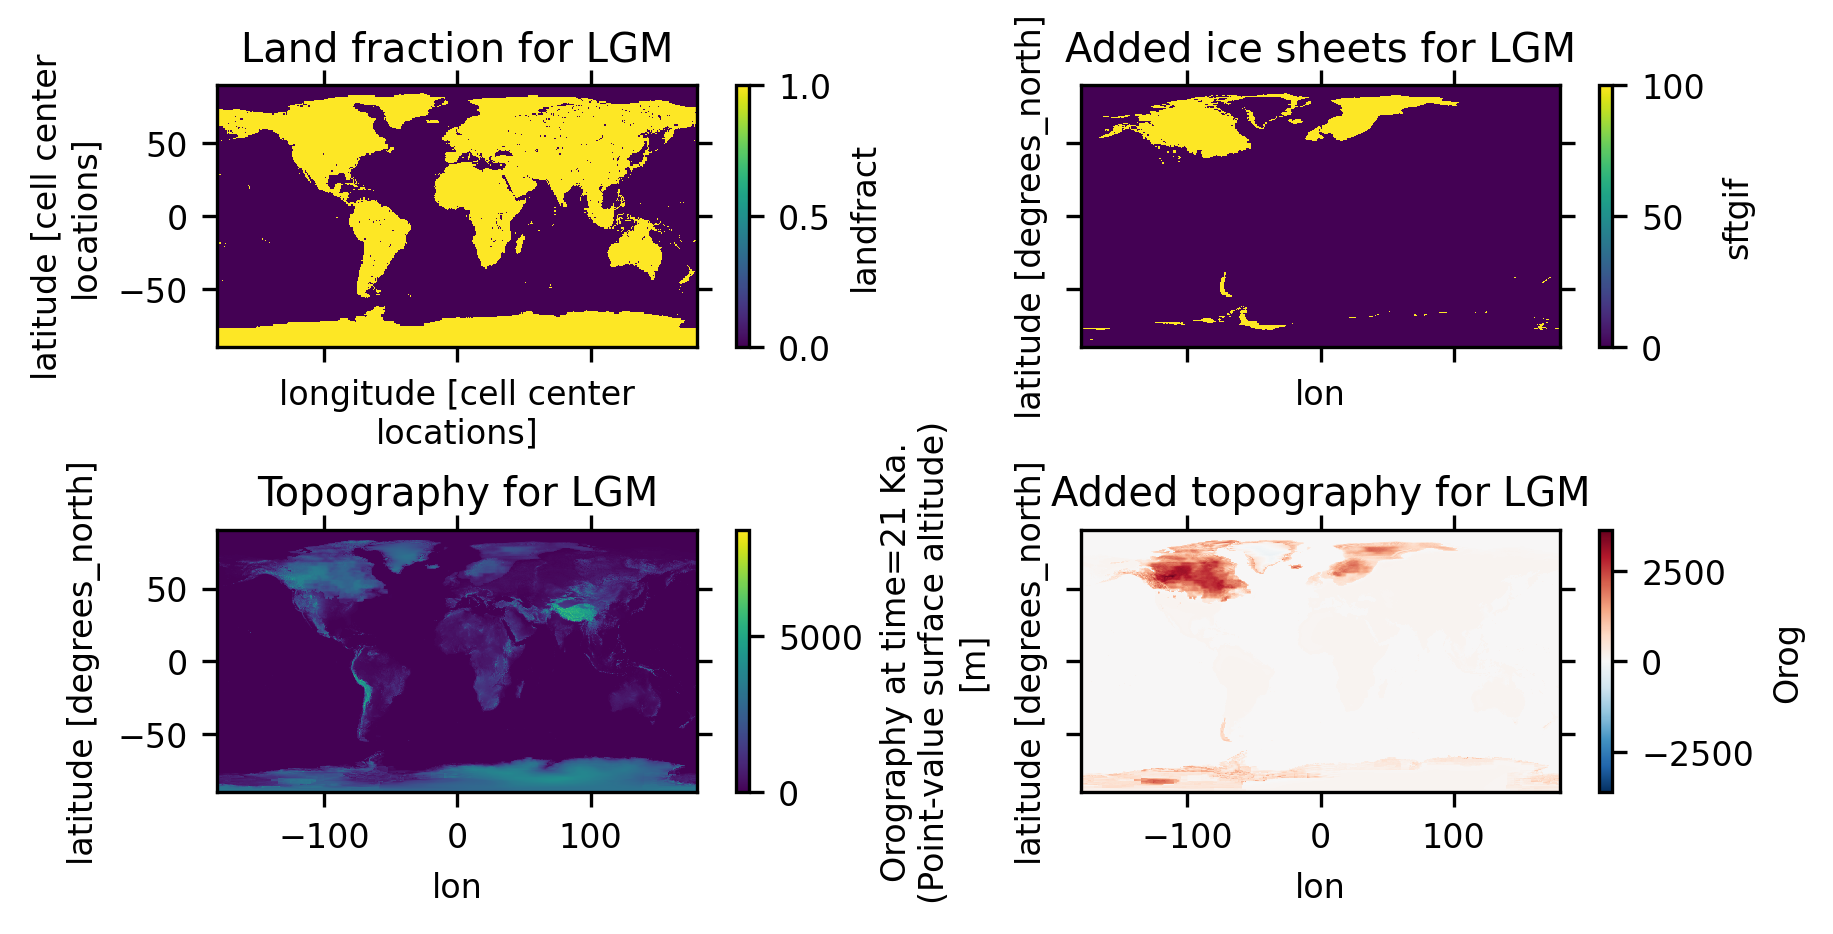

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

lgm_lndf.thin(100).plot(ax=axes[0])
axes[0].set_title('Land fraction for LGM')

glc_ano_i6g.plot(ax=axes[1])
axes[1].set_title('Added ice sheets for LGM')

ice6g_lgm_ds.Orog.plot(ax=axes[2])
axes[2].set_title('Topography for LGM')

topo_ano_i6g.plot(ax=axes[3])
axes[3].set_title('Added topography for LGM')

---
## Step 0: Explore the preindustrial namelist

### Raw files

In [16]:
raw_keys = [key for key in nml_dict['mksurfdata_input'].keys() if
             re.search('mksrf', key) and not re.search('mesh', key)]

for key in raw_keys:
    print(f"{key}: {nml_dict['mksurfdata_input'][key]}")

mksrf_flai: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/pftcftdynharv.0.25x0.25.LUH2.histsimyr1850-2015.c20230226/mksrf_pftlaihgt_ctsm52_histLUH2_2005.c20230226.nc
mksrf_fsoicol: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/pftcftdynharv.0.25x0.25.LUH2.histsimyr1850-2015.c20230226/mksrf_soilcolor_ctsm52_histLUH2_2005.c20230226.nc
mksrf_fsoitex: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_mapunits_5x5min_WISE.c220330.nc
mksrf_fsoitex_lookup: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_lookup.10level.WISE.c220330.nc
mksrf_fmax: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc
mksrf_flakdep: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_LakePnDepth_3x3min_simyr2017_MODISgrid.cdf5.c200305.nc
mksrf_fwetlnd: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_lanwat.050425.nc
mksrf_fvocef: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf

- `ncdump` each file and check the CTSM Tech Note (e.g., [2.2.3.3](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#surface-data)) to figure out the strategy
- We don't change the following files
  - mksrf_fwetlnd: wetland is no long used since CLM4.5.
  - mksrf_flakdep: use the preindustrial should be fine, as will do not create new lakes for the LGM
  - mksrf_fpeat: peat is only used in fire parameterization, which is only relevant if carbon-nitrogen cycle is on. File is not interactive in CTSM?
  - mksrf_fgdp: not relevant in "NoAnthro" mode
  - mksrf_furban: not relevant in "NoAnthro" mode
  - mksrf_fhrvtyp: not relevant in "NoAnthro" mode
  - mksrf_fabm: it is "peak month for agri fire"; not relevant in "NoAnthro" mode
  - mksrf_furbtopo: it is "used only to screen pcturb by elevation threshold"; not relevant in "NoAnthro" mode
- Special files for land units
  - mksrf_fglacier: we add the glacier coverage from ICE-6G
  - mksrf_fglacierregion: we use a new file
  - mksrf_fvegtyp: we cover vegetation with ICE-6G ice sheets and add new vegetation over exposed shelves
  - mksrf_fpctlak: we cover lakes underneath ICE-6G ice sheets
- mksrf_ftopostats: `SLOPE` is used in [Surface Water Storage](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Hydrology/CLM50_Tech_Note_Hydrology.html#surface-water-storage) and `ELEVATION` is used in [Snow Covered Area Fraction](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Snow_Hydrology/CLM50_Tech_Note_Snow_Hydrology.html#snow-covered-area-fraction).
  - This file is hard to work with. We can update `SLOPE` and `STD_ELEV` once we have the LGM surfdata.
- ***NOTE: mksrf_fsoitex misses lat and lon info (LATIXY and LONGXY are all zeros)***
  - I will use lat and lon from mksrf_fsoildepth instead

### Mesh files for mapping
- We don't need to do anything with mesh files, as we are directly modifying the raw files

In [17]:
map_keys = [key for key in nml_dict['mksurfdata_input'].keys() if
             re.search('mksrf', key) and re.search(r'mesh$', key)]

for key in map_keys:
    print(f"{key}: {nml_dict['mksurfdata_input'][key]}")

mksrf_fgrid_mesh: /glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc
mksrf_flai_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoicol_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoitex_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_5x5min_nomask_cdf5_c200129.nc
mksrf_fmax_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.125x0.125_nomask_cdf5_c200129.nc
mksrf_fpctlak_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_3x3min_nomask_cdf5_c200129.nc
mksrf_flakdep_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_3x3min_nomask_cdf5_c200129.nc
mksrf_fwetlnd_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.5x0.5_n

---
## Step 1: Fill the following raw data with nearest neighbor
- The goal is to create land surface properties such as soil color for new land grid points
- `LANDMASK` in these LGM raw files need to be updated as well!

In [18]:
nnfill_keys = ['mksrf_flai', 'mksrf_fsoicol', 'mksrf_fmax', 'mksrf_fvocef', 'mksrf_fsoildepth']

nnfill_dict = {}

nnfill_dict['mksrf_flai'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_flai'],
    'vnames': ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP',
               'MONTHLY_LAI', 'MONTHLY_SAI'],
    'lat_var': 'LAT',  # Variable with values for latitude
    'lon_var': 'LON',
    'lat_dim': 'lat',  # Dimention name
    'lon_dim': 'lon',
}

nnfill_dict['mksrf_fsoicol'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoicol'],
    'vnames': ['SOIL_COLOR'],
    'lat_var': 'LAT',
    'lon_var': 'LON',
    'lat_dim': 'lat',
    'lon_dim': 'lon',
}

nnfill_dict['mksrf_fmax'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_fmax'],
    'vnames': ['FMAX'],
    'lat_var': 'lat',
    'lon_var': 'lon',
    'lat_dim': 'lat',
    'lon_dim': 'lon',
}

nnfill_dict['mksrf_fvocef'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_fvocef'],
    'vnames': ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs', 'ef_shr'],
    'lat_var': 'lat',
    'lon_var': 'lon',
    'lat_dim': 'lat',
    'lon_dim': 'lon',
}

nnfill_dict['mksrf_fsoildepth'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoildepth'],
    'vnames': ['Avg_Depth_Median', 'Avg_Depth_Mean'],
    'lat_var': 'LATIXY',
    'lon_var': 'LONGXY',
    'lat_dim': 'lat',
    'lon_dim': 'lon',
}

nnfill_dict['mksrf_fsoitex'] = {
    'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoitex'],
    'vnames': ['MU'],
    'lat_var': 'LATIXY',  # All zeros, which will cause problem for plotting
    'lon_var': 'LONGXY',  # All zeros, which will cause problem for plotting
    'lat_dim': 'lsmlat',
    'lon_dim': 'lsmlon',
}

- The following cell is needed because mksrf_fsoitex misses lat and lon info

In [19]:
ds_soil = xr.open_dataset(nnfill_dict['mksrf_fsoildepth']['raw_file'])
lat_soil = ds_soil.LATIXY
lon_soil = ds_soil.LONGXY

- This cell seems to be the slowest and you could chang it to `raw` to test the other parts of the notebook

In [20]:
%%time

# for key in ['mksrf_fsoitex']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoicol']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoildepth']:
#     case = nnfill_dict[key]

for key, case in nnfill_dict.items():

    # Figure out the input and output file names
    raw_file = case['raw_file']

    fname = Path(Path(raw_file).name)
    lgm_raw_file = f"{work_dir}/{fname.stem}_21ka_nnfilled{fname.suffix}"

    print(f"{key}: {case['vnames']}")
    print(f"Raw input: {raw_file}")
    print(f"Output: {lgm_raw_file}\n")

    ds = xr.open_dataset(raw_file)

    # Mask each variable first and then fill nans with nearest neighbor
    for vname in case['vnames']:

        # Soiltex file does not have a land mask
        if vname == 'MU':
            ds['LANDMASK'] = xr.where(ds.MU > 0, 1, 0)

        dims_order = ds[vname].dims
        var_masked = xr.where(ds.LANDMASK > 0, ds[vname], np.nan).transpose(*dims_order)

        ds[vname].data = fill_na(var_masked, case['lon_dim'], case['lat_dim'], n_points)

    lat = ds[case['lat_var']]
    lon = ds[case['lon_var']]
    if key == 'mksrf_fsoitex':
        lat = lat_soil
        lon = lon_soil

    lgm_lndf_interp = lgm_lndf.interp(lat=lat, lon=lon, method='linear')

    ds.LANDMASK.data = xr.where(
        (ds.LANDMASK < 1) & (lgm_lndf_interp.values > 0.5), 1, ds.LANDMASK)

    # Save each raw file and update the LGM namelist
    case['lgm_raw_file'] = lgm_raw_file

    lgm_nml_dict['mksurfdata_input'][key] = lgm_raw_file
    ds.to_netcdf(lgm_raw_file)
    subprocess.run(['ncks', "-hO5", lgm_raw_file, lgm_raw_file])

mksrf_flai: ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/pftcftdynharv.0.25x0.25.LUH2.histsimyr1850-2015.c20230226/mksrf_pftlaihgt_ctsm52_histLUH2_2005.c20230226.nc
Output: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_pftlaihgt_ctsm52_histLUH2_2005.c20230226_21ka_nnfilled.nc



/glade/work/jiangzhu/conda-envs/my-npl/lib/python3.12/site-packages/dask/config.py:787: FutureWarning: Dask configuration key 'allowed-failures' has been deprecated; please use 'distributed.scheduler.allowed-failures' instead
  warnings.warn(


mksrf_fsoicol: ['SOIL_COLOR']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/pftcftdynharv.0.25x0.25.LUH2.histsimyr1850-2015.c20230226/mksrf_soilcolor_ctsm52_histLUH2_2005.c20230226.nc
Output: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_soilcolor_ctsm52_histLUH2_2005.c20230226_21ka_nnfilled.nc

mksrf_fmax: ['FMAX']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc
Output: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_fmax_0.125x0.125_c200220_21ka_nnfilled.nc

mksrf_fvocef: ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs', 'ef_shr']
Raw input: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_vocef_0.5x0.5_simyr2000.c110531.nc
Output: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_vocef_0.5x0.5_simyr2000.c110531_21ka_nnfilled.nc

mksrf_fsoildepth: ['Avg_Depth_Median', 'Avg_Depth_Mean']
Raw input: /glade/campaign/cesm/cesmdata/inputdata

/glade/work/jiangzhu/conda-envs/my-npl/lib/python3.12/site-packages/IPython/core/magics/execution.py:1350: SerializationWarning: saving variable MU with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code, glob, local_ns)


CPU times: user 9min 58s, sys: 2min 33s, total: 12min 32s
Wall time: 12min 59s


### Make plots to check results
- For simplicity, I compute and plot 2D fields (mean over non-lat and non-lon dimensions)

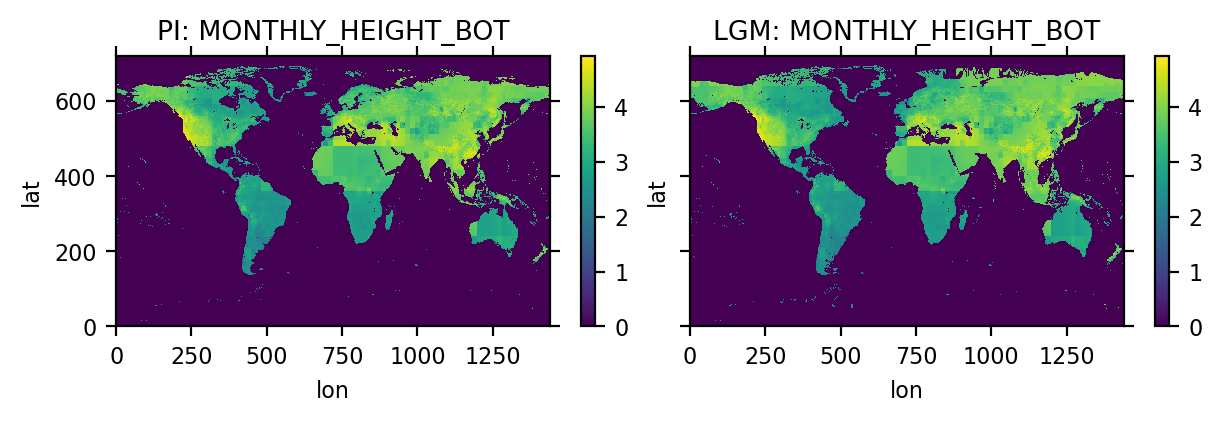

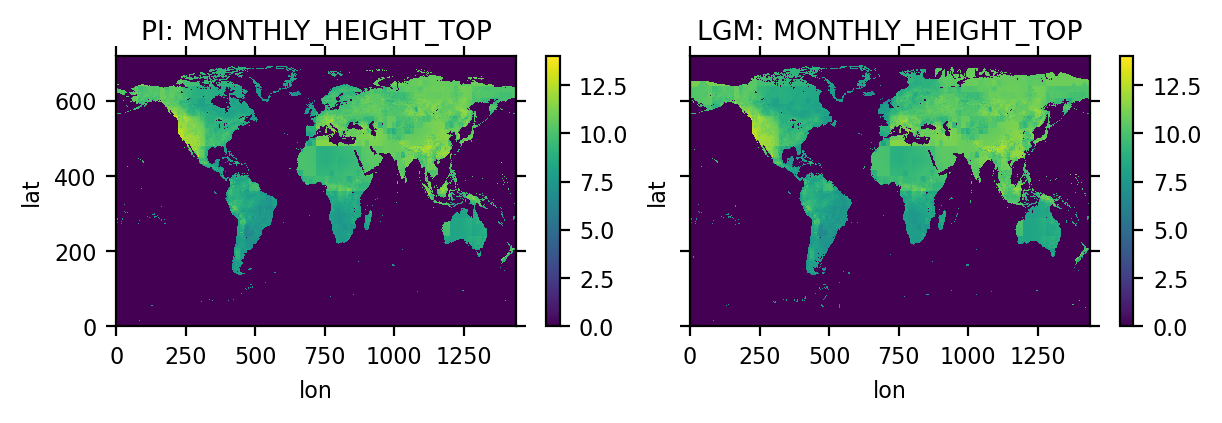

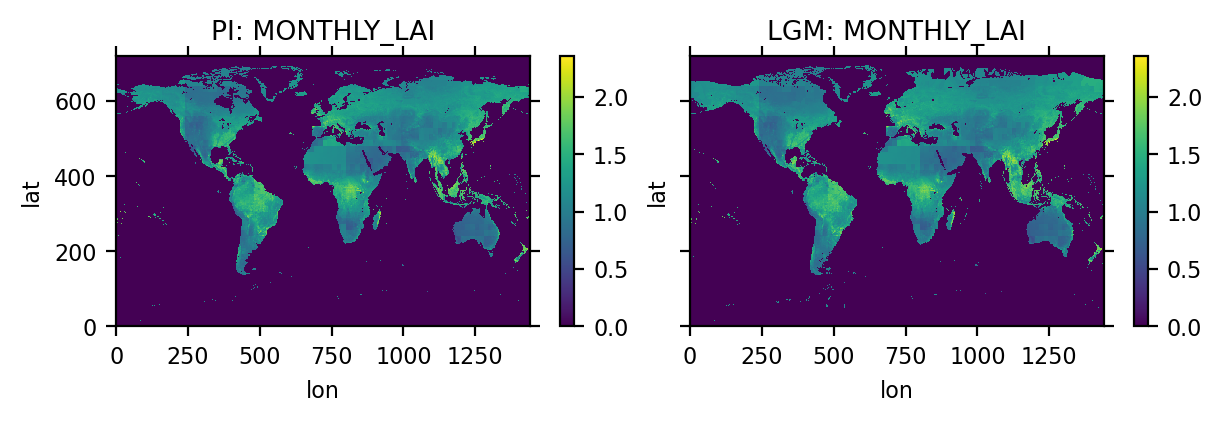

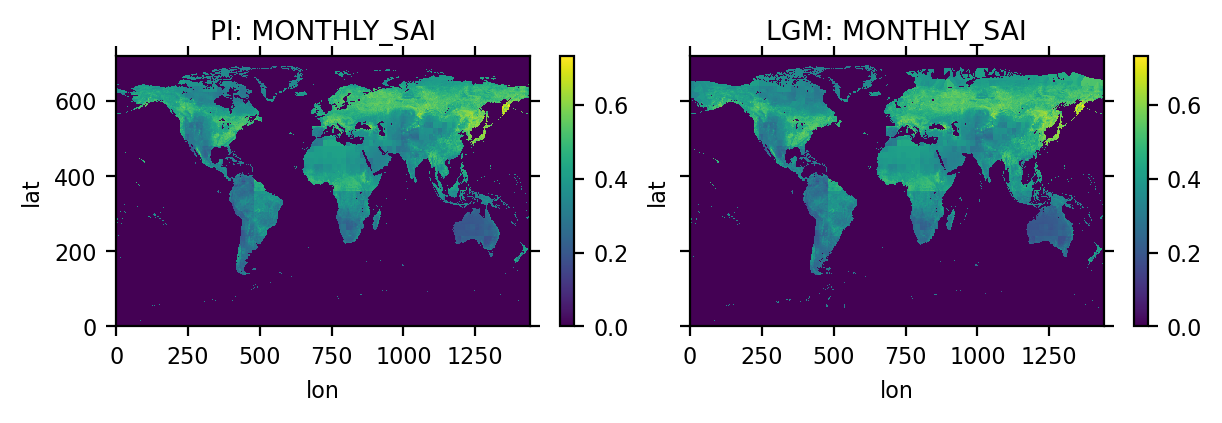

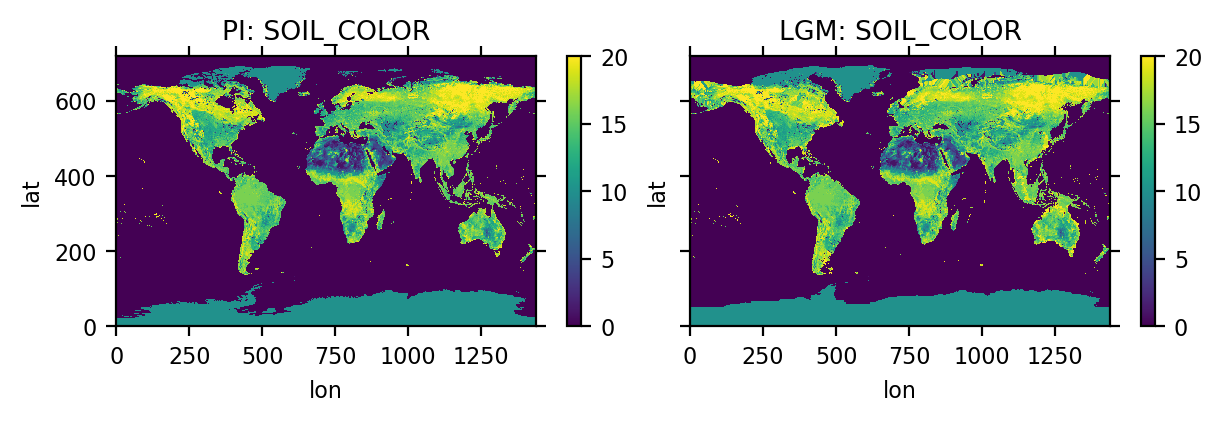

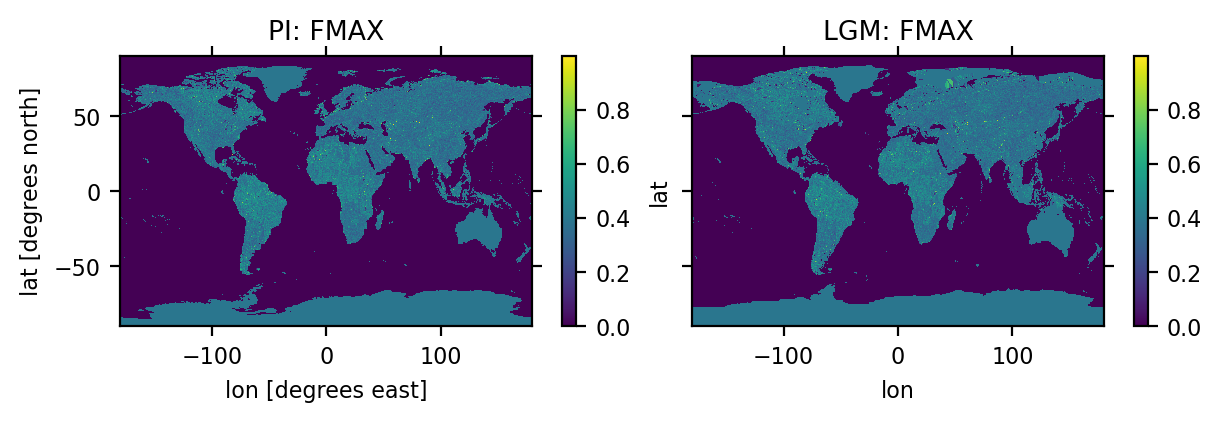

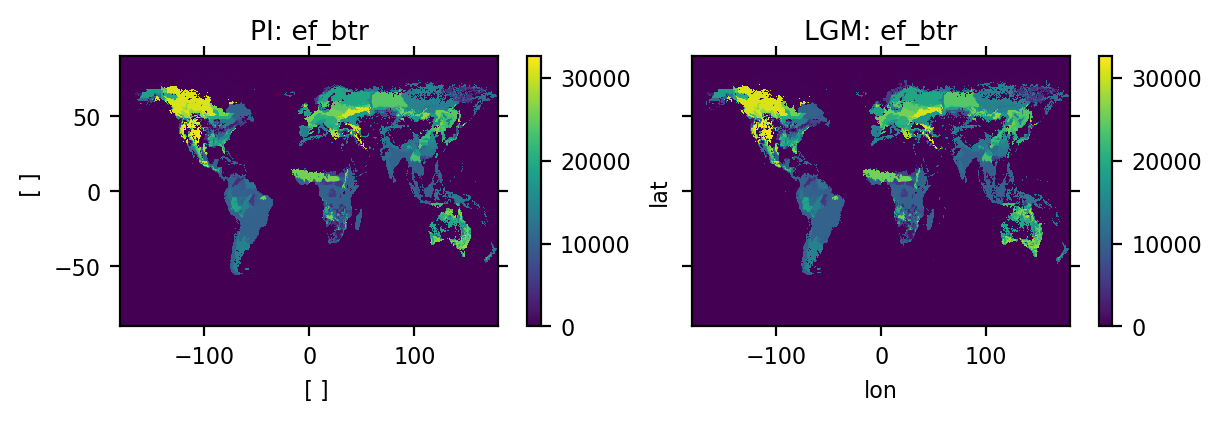

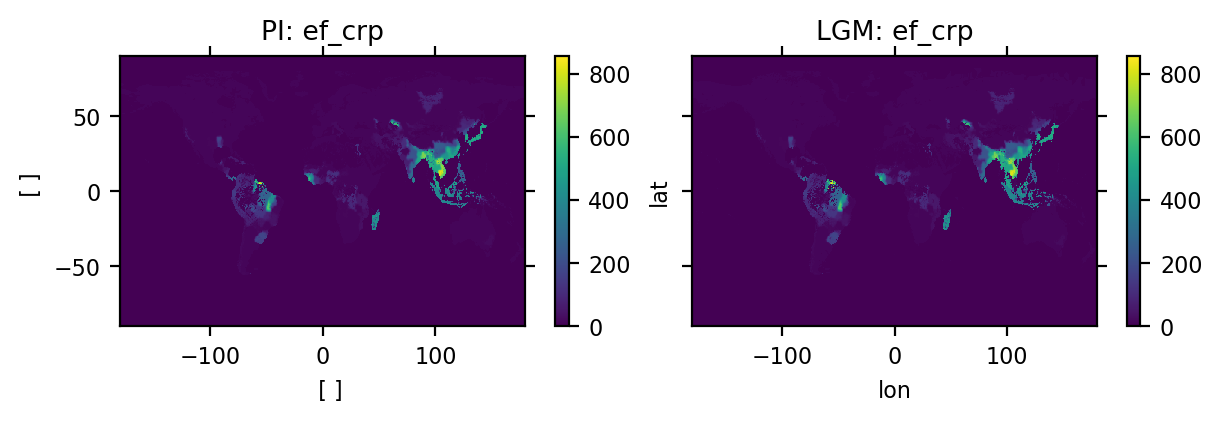

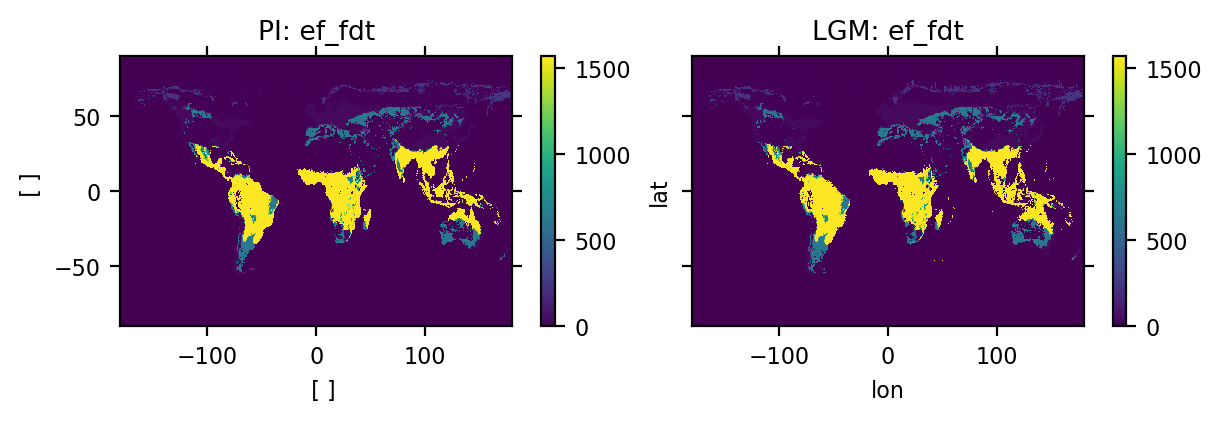

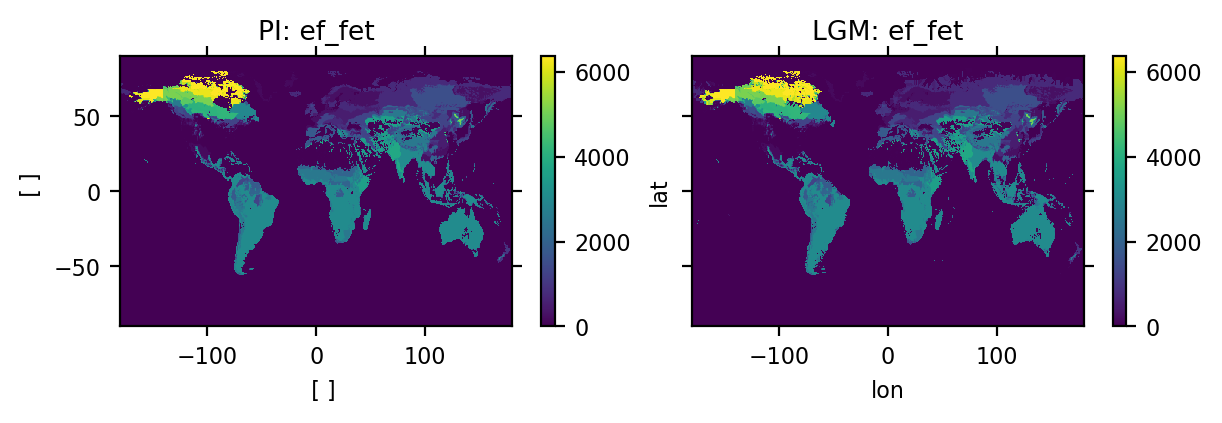

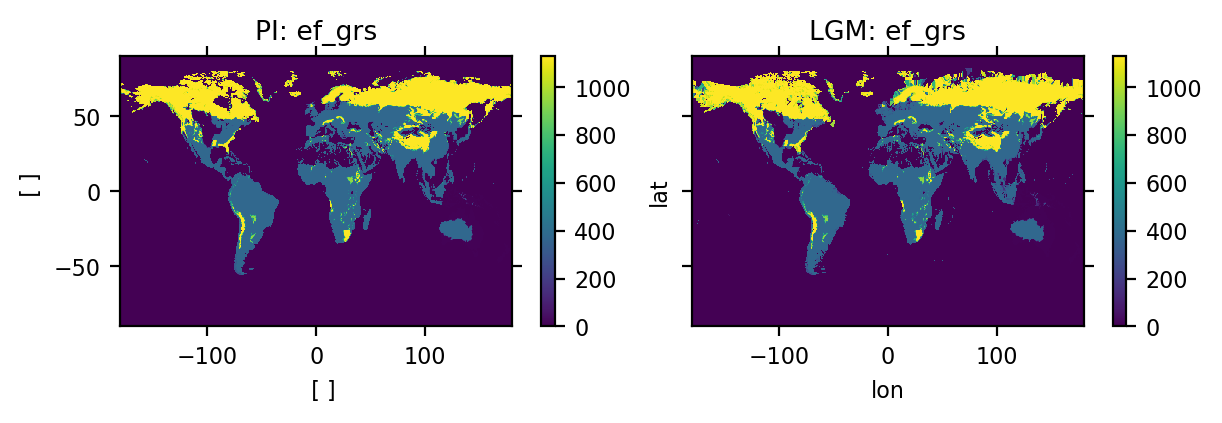

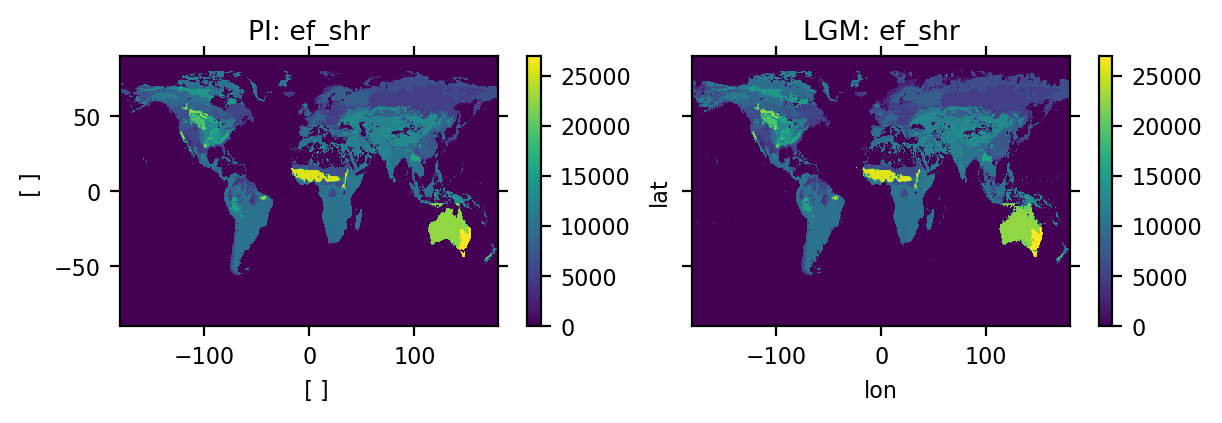

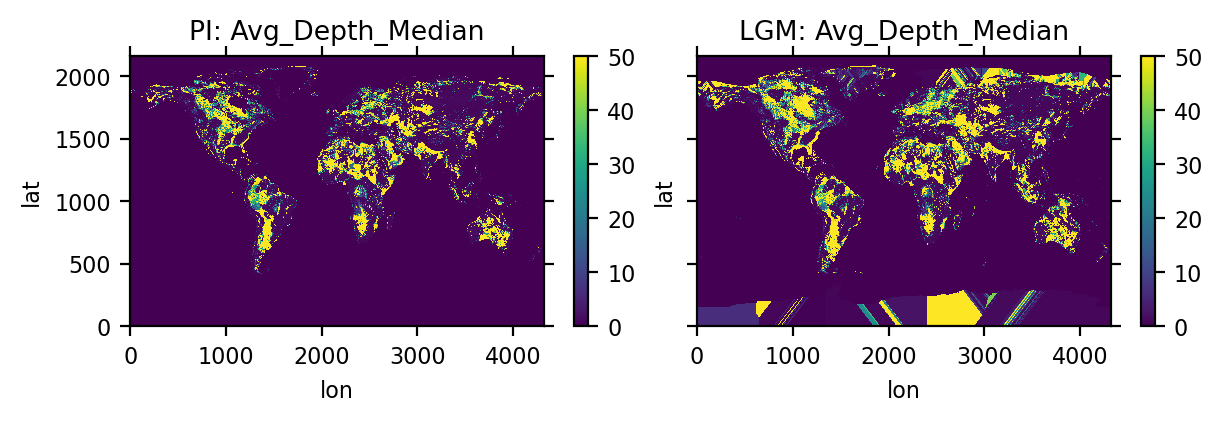

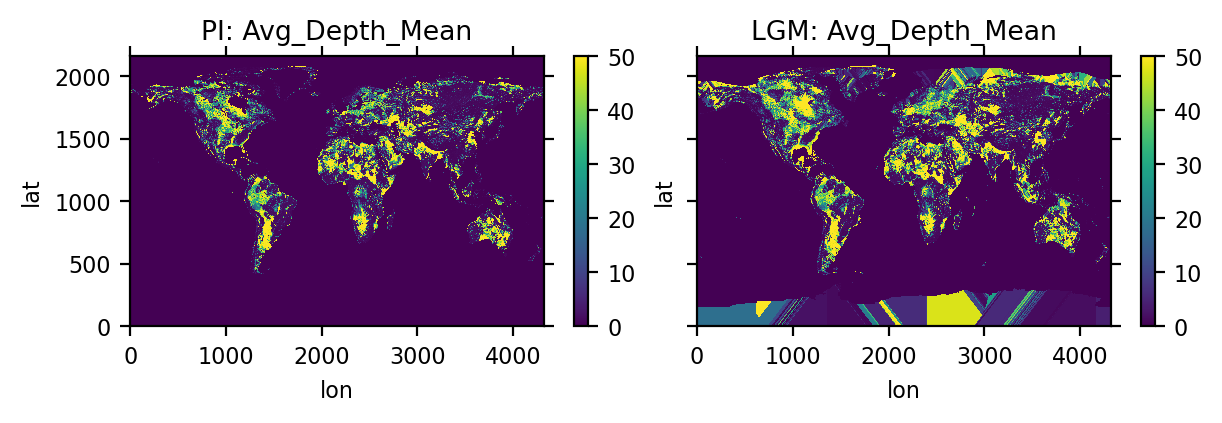

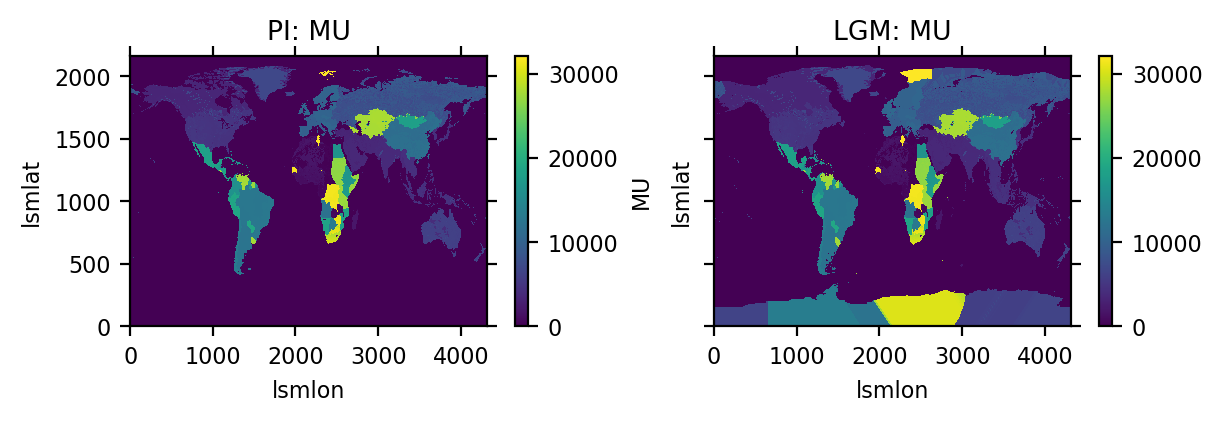

In [21]:
for key, case in nnfill_dict.items():

    ds = xr.open_dataset(case['raw_file'])
    ds_lgm = xr.open_dataset(case['lgm_raw_file'])

    for vname in case['vnames']:
        fig, axes = plt.subplots(
            1, 2, figsize=(6, 2), dpi=200, sharex=True, sharey=True,
            constrained_layout=True)

        # Soiltex file does not have a land mask
        if vname == 'MU':
            lmask = xr.where(ds.MU > 0, 1, 0)
        else:
            lmask = ds.LANDMASK

        lmask_lgm = ds_lgm.LANDMASK

        var = (ds[vname] * lmask).sortby(case['lon_dim'])
        var.mean(
            dim=[dim for dim in ds.dims if dim not in [
                case['lon_dim'], case['lat_dim']]]).plot(ax=axes[0])
        axes[0].set_title(f"PI: {vname}")

        var_lgm = (ds_lgm[vname] * lmask_lgm).sortby(case['lon_dim'])
        var_lgm.mean(
            dim=[dim for dim in ds.dims if dim not in [
                case['lon_dim'], case['lat_dim']]]).plot(ax=axes[1])
        axes[1].set_title(f"LGM: {vname}")

---
## Step 2: Remove lakes underneath the LGM ice sheets
- `LANDMASK` in the lake file is not used by mksurfdata_esmf

In [22]:
pctlak_file = nml_dict['mksurfdata_input']['mksrf_fpctlak']
ds_pctlak = xr.open_dataset(pctlak_file)

fname = Path(Path(pctlak_file).name)
lgm_pctlak_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_pctlak_file)

ds_pctlak

/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325_21ka.nc


<xarray.Dataset> Size: 830MB
Dimensions:   (lat: 3600, lon: 7200)
Coordinates:
  * lat       (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.87 89.92 89.97
  * lon       (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    PCT_LAKE  (lat, lon) float64 207MB ...
    LANDMASK  (lat, lon) float64 207MB ...
    LATIXY    (lat, lon) float64 207MB ...
    LONGXY    (lat, lon) float64 207MB ...
Attributes:
    source:         HydroLAKES polygons dataset v1.0 June 2019
    title:          Percent Lake calculated from the Hydrolakes dataset mappe...
    references:     Messager, M.L., Lehner, B., Grill, G., Nedeva, I., Schmit...
    url:            https://www.hydrosheds.org/pages/hydrolakes
    creation_date:  Thu Mar  5 13:41:39 2020

### Regrid the LGM added glacier coverage to the grid of lake file

In [23]:
glc_ano_i6g_int = glc_ano_i6g.interp(
    lat=ds_pctlak.lat, lon=ds_pctlak.lon, method='linear',
    kwargs={"fill_value": "extrapolate"})
glc_ano_i6g_int

<xarray.DataArray 'sftgif' (lat: 3600, lon: 7200)> Size: 207MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.87 89.92 89.97
  * lon      (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

### Remove lakes underneath ice sheets, save output and update the LGM namelist

In [24]:
ds_pctlak_lgm = ds_pctlak.copy(deep=True)

ds_pctlak_lgm.PCT_LAKE.data = xr.where(
    glc_ano_i6g_int > 50, 0, ds_pctlak.PCT_LAKE)

ds_pctlak_lgm.to_netcdf(lgm_pctlak_file)
subprocess.run(['ncks', "-hO5", lgm_pctlak_file, lgm_pctlak_file])

lgm_nml_dict['mksurfdata_input']['mksrf_fpctlak'] = lgm_pctlak_file

### Make plot to check results

Text(0.5, 1.0, 'LGM Changes')

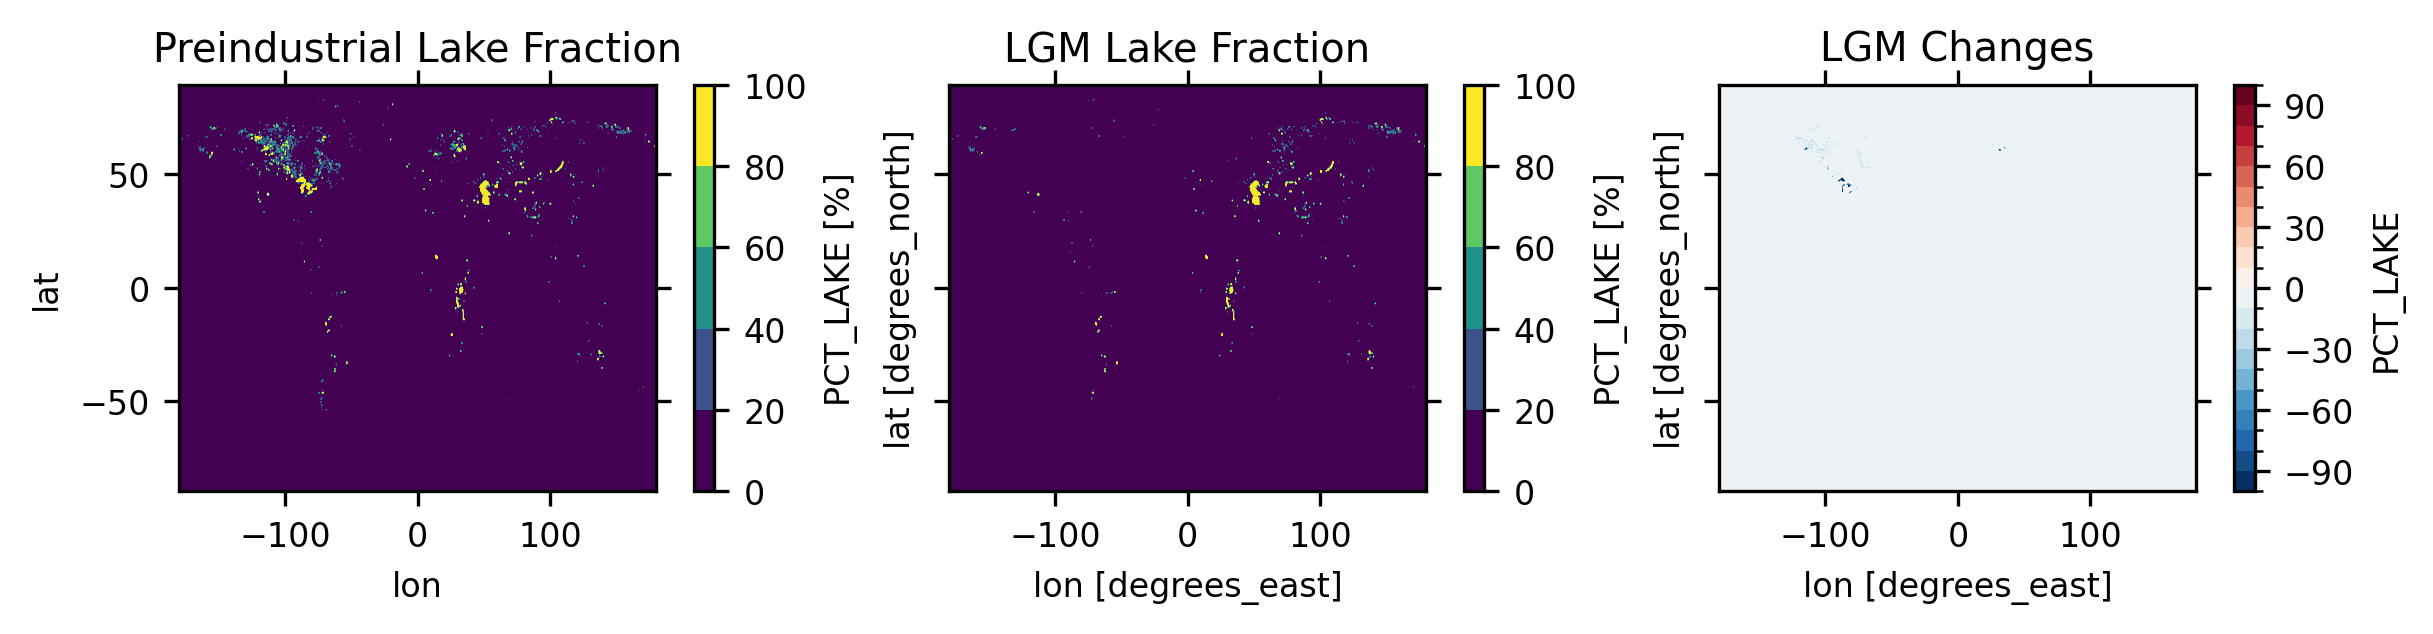

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pctlak.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[0])
axes[0].set_title('Preindustrial Lake Fraction')

ds_pctlak_lgm.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[1])
axes[1].set_title('LGM Lake Fraction')

(ds_pctlak_lgm - ds_pctlak).PCT_LAKE.thin(10).plot.contourf(
    ax=axes[2], cmap='RdBu_r', levels=np.linspace(-100, 100, 21))
axes[2].set_title('LGM Changes')

---
## Step 3: Add PFTs over new LGM land points and remove PFTs underneath LGM ice sheets
- `LANDFRAC` in mksrf_fvegtyp is used as land fraction for the entire surfdata?
- `LANDMASK`, when mutiplied by 100, is the same as `PCT_NAT_PFT.sum('natpft')` to round-off error

In [26]:
pft_file = nml_dict['mksurfdata_input']['mksrf_fvegtyp']
ds_pft = xr.open_dataset(pft_file)
ds_pft_lgm = ds_pft.copy(deep=True)

fname = Path(Path(pft_file).name)
lgm_pft_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_pft_file)

ds_pft

/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_landuse_ctsm52_noanthroLUH2_1.c20230226_21ka.nc


<xarray.Dataset> Size: 2GB
Dimensions:                  (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 256B 15 16 17 18 19 ... 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables: (12/28)
    EDGEN                    float32 4B ...
    EDGEE                    float32 4B ...
    EDGES                    float32 4B ...
    EDGEW                    float32 4B ...
    LAT                      (lat) float32 3kB ...
    LATIXY                   (lat, lon) float32 4MB ...
    ...                       ...
    HARVEST_SH1              (lat, lon) float64 8MB ...
    HARVEST_SH2              (lat, lon) float64 8MB ...
    HARVEST_SH3              (lat, lon) float64 8MB ...
    GRAZING                  (lat, lon) float64 8MB ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 124MB ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 531MB ...
Attributes: (12/16)
    Conventions:        NCAR-CSM
    Author:             Peter Lawrence, lawrence@ucar.edu, NCAR, Terrestrial ...
    History_Log:        c20230226
    Region:             /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    CTSMCurrentDB:      /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    CTSMForestDB:       /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    ...                 ...
    CTSMC3PerDB:        /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    CTSMC4PerDB:        /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    CTSMC3NfxDB:        /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/ctsm52l...
    LUH2StatesDB:       /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/lumip52...
    LUH2ManagementDB:   /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/lumip52...
    LUH2TransitionsDB:  /glade/p/cesm/sdwg_dev/thesis/data/cesm_tools/lumip52...

### Update`LANDFRAC` and `LANDMASK` in the LGM pft file and make plots

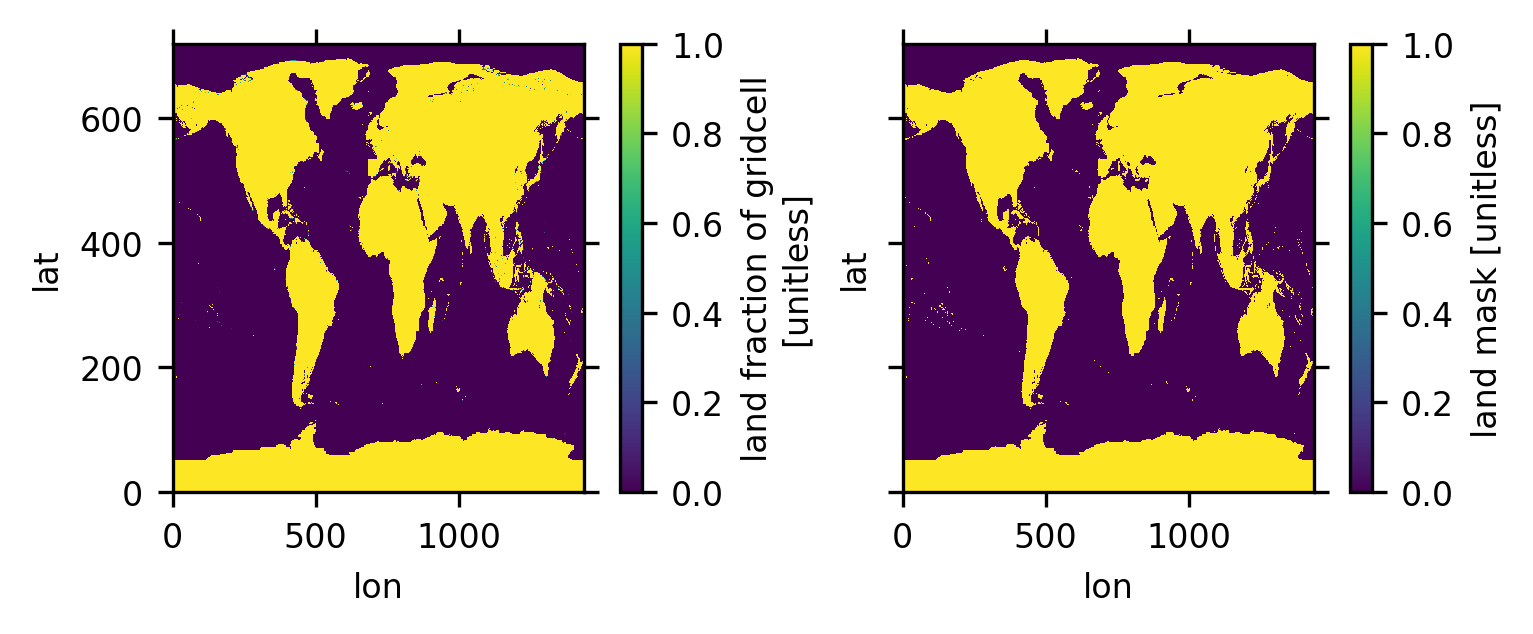

In [27]:
lgm_lndf_interp = lgm_lndf.interp(
    lat=ds_pft.LAT, lon=ds_pft.LON, method='linear',
    kwargs={"fill_value": "extrapolate"})

ds_pft_lgm.LANDFRAC.data = xr.where(
    lgm_lndf_interp > ds_pft.LANDFRAC, lgm_lndf_interp, ds_pft.LANDFRAC)

ds_pft_lgm.LANDMASK.data = xr.where(ds_pft_lgm.LANDFRAC > 0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
ds_pft_lgm.LANDFRAC.plot(ax=axes[0])
ds_pft_lgm.LANDMASK.plot(ax=axes[1])

### Add PFTs to `PCT_NATVEG` with nearest neighbor and then remove PFTs underneath ice sheets
- Scaling over coasts is needed? CTSM [1730](https://github.com/ESCOMP/CTSM/issues/1703) and [1716](https://github.com/ESCOMP/CTSM/issues/1716)
- If PCT_PFT, PCT_LAK, etc does not sum to 100% over the new LGM land, it will be scaled to 100% in mksurfdata_exe?

In [28]:
dims_order = ds_pft_lgm.PCT_NATVEG.dims
pct_natveg_masked = xr.where(
    ds_pft.LANDMASK > 0, ds_pft_lgm.PCT_NATVEG / ds_pft.LANDFRAC / 100, np.nan).transpose(*dims_order)

ds_pft_lgm.PCT_NATVEG.data = fill_na(pct_natveg_masked, 'lon', 'lat', n_points)

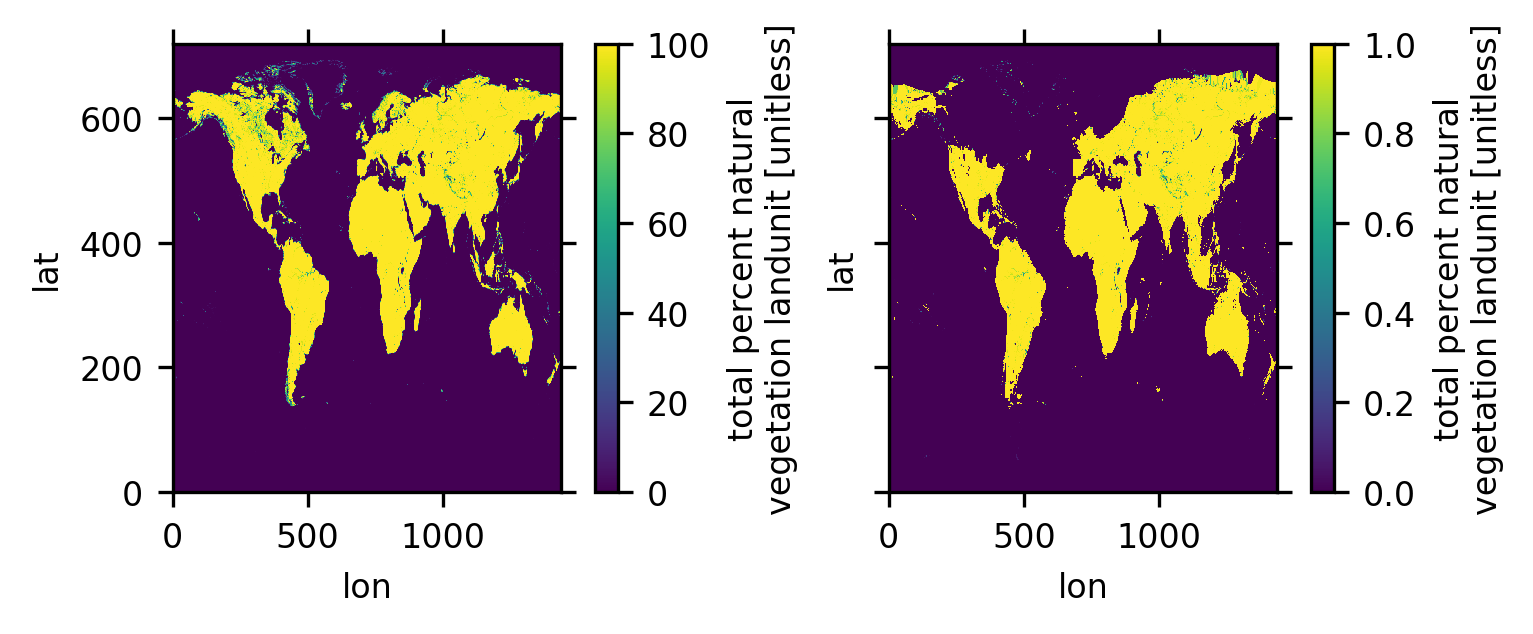

In [29]:
glc_ano_i6g_int = glc_ano_i6g.interp(
    lat=ds_pft_lgm.LAT, lon=ds_pft_lgm.LON, method='linear',
    kwargs={"fill_value": "extrapolate"})

ds_pft_lgm.PCT_NATVEG.data = xr.where(
    glc_ano_i6g_int.data > 50, 0, ds_pft_lgm.PCT_NATVEG)*ds_pft_lgm.LANDFRAC

fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
ds_pft.PCT_NATVEG.plot(ax=axes[0])
ds_pft_lgm.PCT_NATVEG.plot(ax=axes[1])

### Add PFTs to `PCT_NAT_PFT` with nearest neighbor

In [30]:
dims_order = ds_pft_lgm.PCT_NAT_PFT.dims
pct_nat_pft_masked = xr.where(
    ds_pft.LANDMASK > 0, ds_pft_lgm.PCT_NAT_PFT, np.nan).transpose(*dims_order)

ds_pft_lgm.PCT_NAT_PFT.data = fill_na(
    pct_nat_pft_masked, 'lon', 'lat', n_points) * ds_pft_lgm.LANDMASK

### Save the LGM PFT file and update the namelist

In [31]:
ds_pft_lgm.to_netcdf(lgm_pft_file)
subprocess.run(['ncks', "-hO5", lgm_pft_file, lgm_pft_file])

lgm_nml_dict['mksurfdata_input']['mksrf_fvegtyp'] = lgm_pft_file
lgm_nml_dict['mksurfdata_input']['mksrf_fhrvtyp'] = lgm_pft_file

### Make plots to check results

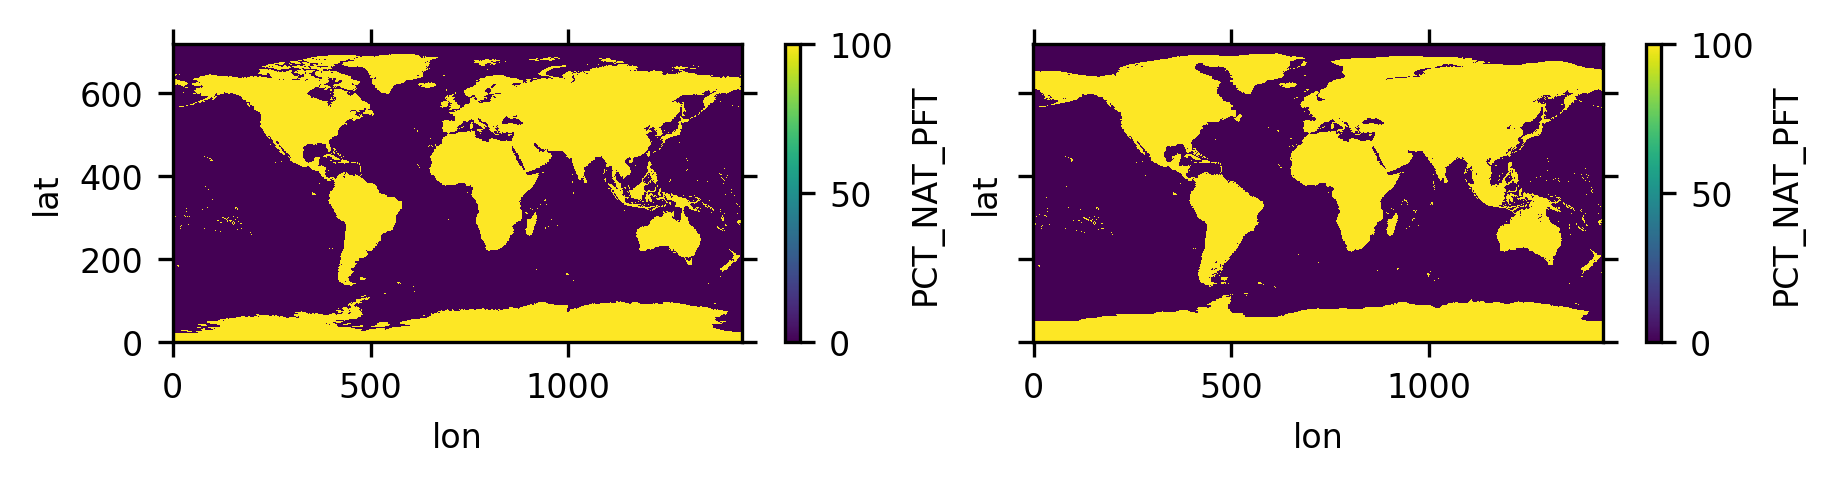

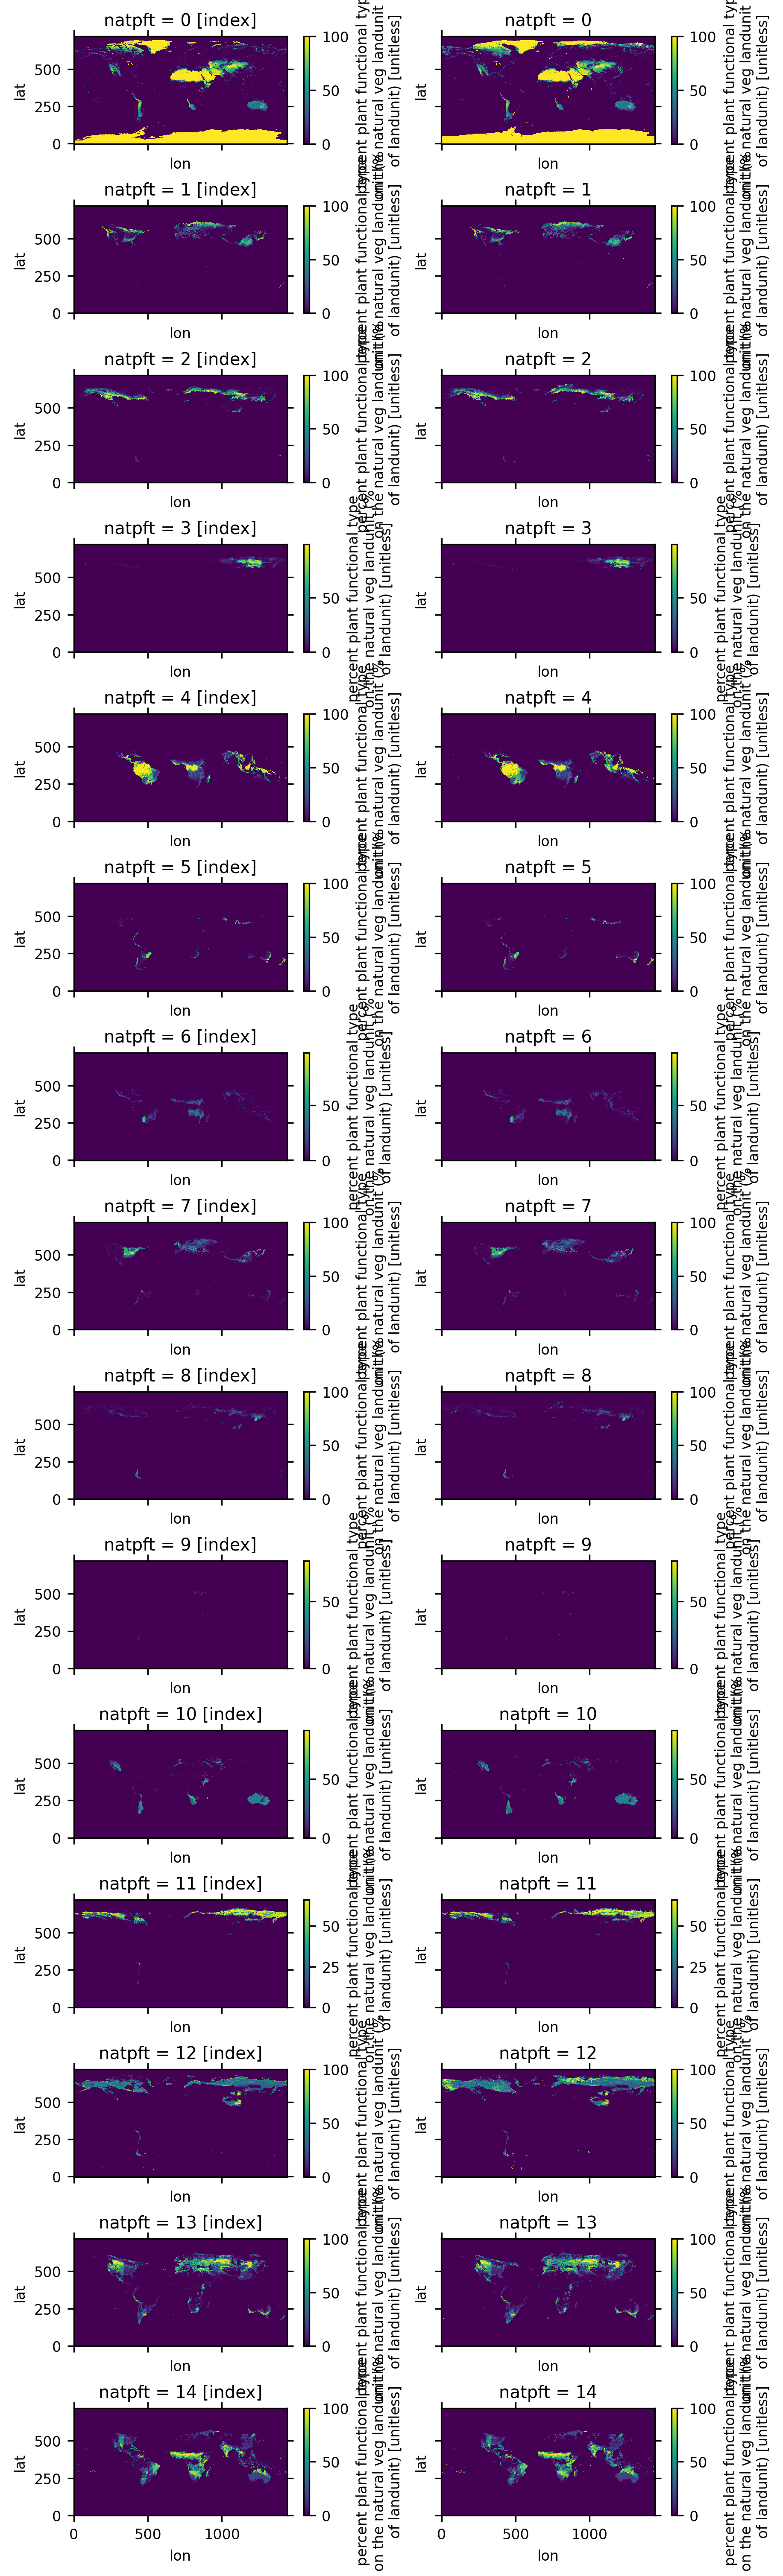

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(6, 1.5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pft.PCT_NAT_PFT.sum('natpft').plot(ax=axes[0])
ds_pft_lgm.PCT_NAT_PFT.sum('natpft').plot(ax=axes[1])

fig, axes = plt.subplots(15, 2, figsize=(6, 20),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i_pft in ds_pft_lgm.natpft.values:
    ds_pft.PCT_NAT_PFT.isel(natpft=i_pft).plot(ax=axes[i_pft, 0])
    ds_pft_lgm.PCT_NAT_PFT.isel(natpft=i_pft).plot(ax=axes[i_pft, 1])

---
## Step 4: Create the LGM mksrf_fglacier
- Somehow, PCT_GLACIER, PCT_GLC_ICESHEET.sum('z'), and PCT_GLC_GIC.sum('z') in the preindustrial raw file could be slightly greater than 100%, likely due to interpolation. I am going to ignore this inconsistency.

In [33]:
glc_file = nml_dict['mksurfdata_input']['mksrf_fglacier']
ds_glc = xr.open_dataset(glc_file)

ds_glc_lgm = ds_glc.copy(deep=True)

fname = Path(Path(glc_file).name)
lgm_glc_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"
print(lgm_glc_file)

ds_glc

/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_glacier_3x3min_simyr2000.c20210708_21ka.nc


<xarray.Dataset> Size: 15GB
Dimensions:           (lat: 3600, lon: 7200, z: 71, z_edge: 72)
Dimensions without coordinates: lat, lon, z, z_edge
Data variables:
    PCT_GLACIER       (lat, lon) float32 104MB ...
    LANDMASK          (lat, lon) float32 104MB ...
    TOPO              (lat, lon) float32 104MB ...
    BIN_CENTERS       (z) float32 284B ...
    BIN_EDGES         (z_edge) float32 288B ...
    LAT               (lat) float32 14kB ...
    LON               (lon) float32 29kB ...
    LATIXY            (lat, lon) float32 104MB ...
    LONGXY            (lat, lon) float32 104MB ...
    PCT_GLC_GIC       (z, lat, lon) float32 7GB ...
    PCT_GLC_ICESHEET  (z, lat, lon) float32 7GB ...
Attributes:
    creation_date:  Thu Jul  8 18:53:28 MDT 2021
    title:          CTSM percent glacier dataset and associated topography ve...
    summary:        (See description.)
    creator:        Rene Wijngaard and Adam Herrington
    contact:        CISM Subboard at https://bb.cgd.ucar.edu
    data_script:    https://docs.google.com/document/d/1HZxoyzvcnIpt6q6OuO_L6...
    description:    The updated glacier dataset (version 2) uses glacier outl...

### Make plots of variables

0.0
0.0
100.00001525878906
100.00001525878906
100.00001525878906


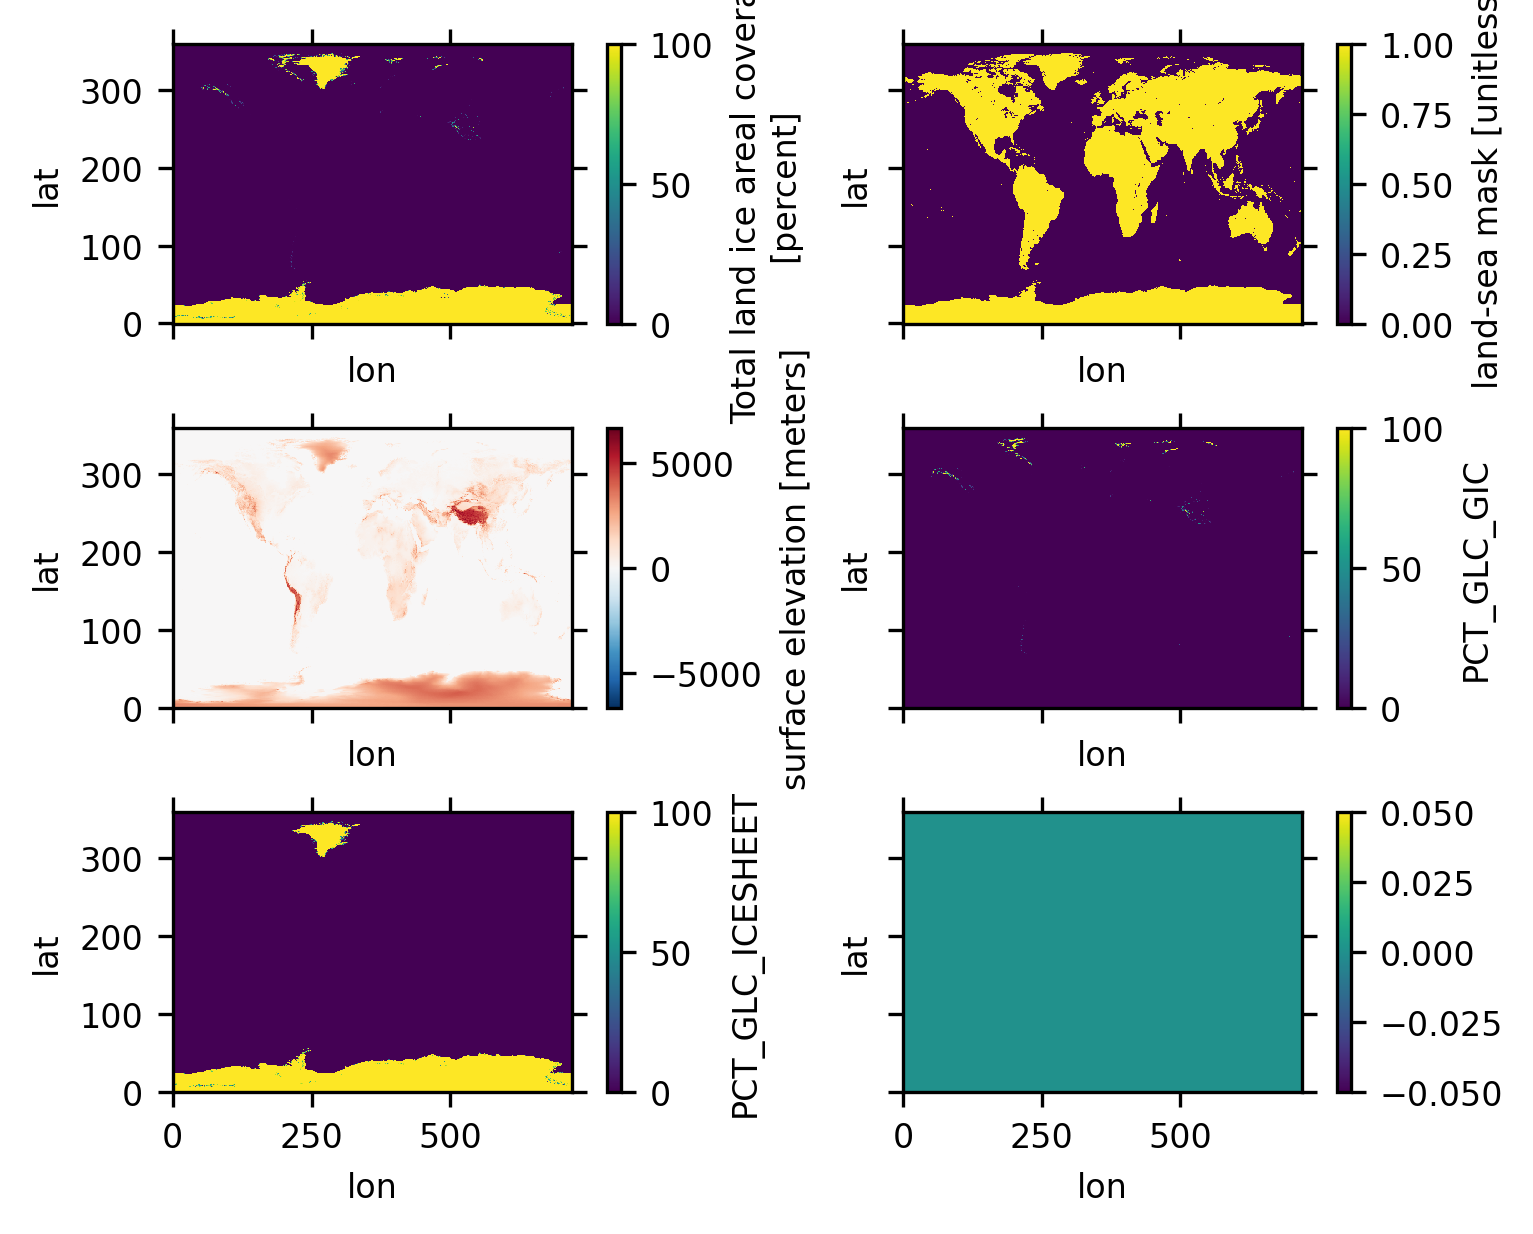

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for vname, ax in zip(
    ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET'],
    axes,
):
    var = ds_glc[vname]
    if vname == 'PCT_GLC_GIC' or vname =='PCT_GLC_ICESHEET':
        var = ds_glc[vname].sum('z')
    var.thin(10).plot(ax=ax)
    
var = ds_glc['PCT_GLACIER'] - (ds_glc['PCT_GLC_GIC'] + ds_glc['PCT_GLC_ICESHEET']).sum('z')
var.thin(10).plot(ax=axes[5])
print(var.max().values)
print(var.min().values)

print(ds_glc.PCT_GLACIER.max().values)
print(ds_glc.PCT_GLC_ICESHEET.sum('z').max().values)
print(ds_glc.PCT_GLC_GIC.sum('z').max().values)

### Take a look at Greenland Summit

In [35]:
idx_lat = 3250
idx_lon = 2800

idx_lat = 3250
idx_lon = 2600

idx_lat = 3250
idx_lon = 2550

ds = ds_glc

print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)

print(bins_c[bin_idx-1])

print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

Examine point: lat = 72.53, lon = -52.47
PCT_GLACIER: 100.0
LANDMASK: 1.0
TOPO: 1597.8160400390625
PCT_GLC_GIC: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PCT_GLC_ICESHEET: [ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.       52.933975 47.066025  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0

### Step 4.1 Create the LGM LANDMASK and TOPO

In [36]:
lgm_lndf_interp = lgm_lndf.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear',
    kwargs={"fill_value": "extrapolate"})

ds_glc_lgm.LANDMASK.data = xr.where(
    (ds_glc.LANDMASK < 1) & (lgm_lndf_interp.values > 0.5), 1, ds_glc.LANDMASK)

In [37]:
glc_ano_i6g_int = topo_ano_i6g.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear',
    kwargs={"fill_value": "extrapolate"})

ds_glc_lgm.TOPO.data = ds_glc.TOPO + glc_ano_i6g_int

print(f"Preindustrial topo height: max = {ds_glc.TOPO.max().values:5.2f}, min = {ds_glc.TOPO.min().values:5.2f}")
print(f"New LGM topo height: max = {ds_glc_lgm.TOPO.max().values:5.2f}, min = {ds_glc_lgm.TOPO.min().values:5.2f}")

Preindustrial topo height: max = 7881.95, min = -412.00
New LGM topo height: max = 7971.42, min = -404.11


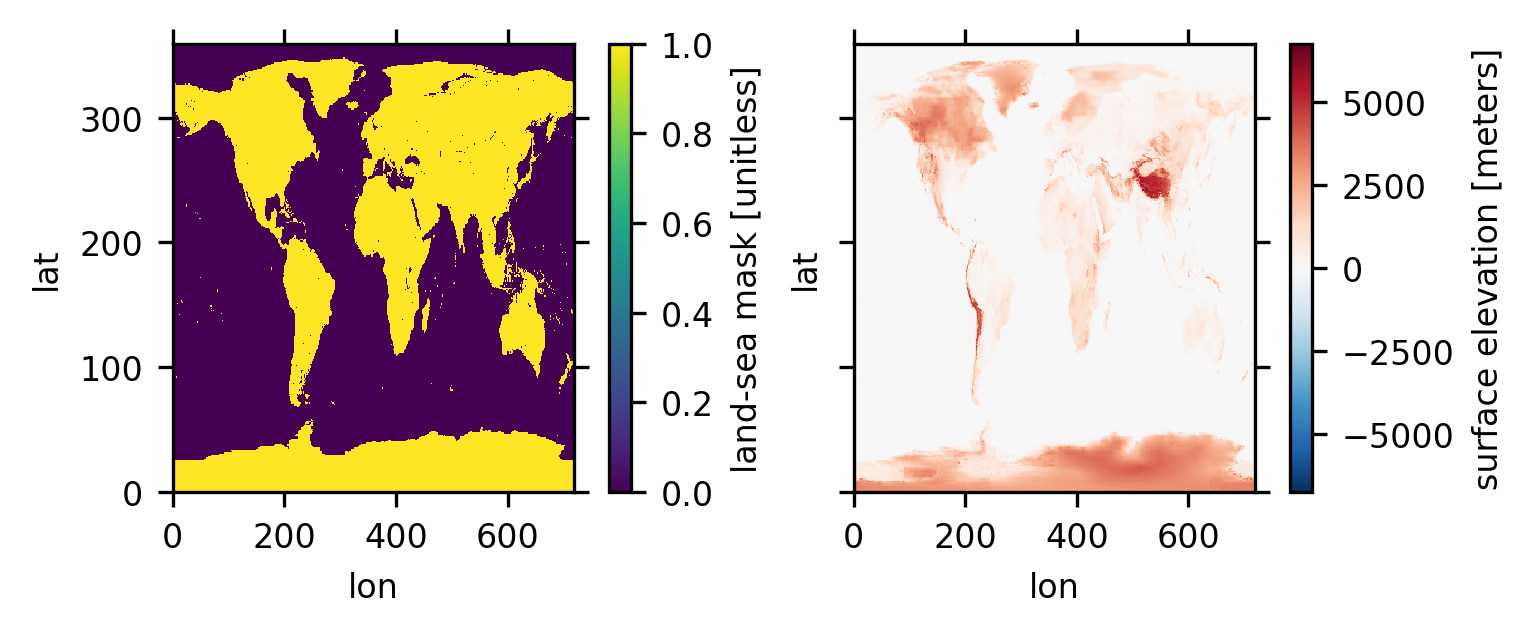

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_glc_lgm.LANDMASK.thin(10).plot.pcolormesh(ax=axes[0])
ds_glc_lgm.TOPO.thin(10).plot.pcolormesh(ax=axes[1])

### Step 4.2 Create PCT_GLC_GIC and PCT_GLC_ICESHEET
- For simplicity, I did not adjust non-LGM-glaciated regions. For example, glaciers (`PCT_GLC_GIC`) over the Himalaya are not changes in coverage and elevation class.
  - It is imperfect to ingore the sea level and GIA effects (i.e. the Himalayan glaciers should have been in higher elevation class) but I don't think it impacts simulation results much.
  - It should be more accurate if we directly work with the orignal land ice coverage data in 30arcsec.

LGM ICE-G ice sheet pct: max = 100.0, min = 0.0


<xarray.DataArray 'sftgif' (lat: 3600, lon: 7200)> Size: 104MB
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon      (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    valid_max:      100.0
    valid_min:      0.0
    time:            21.00 KBP
    units:          %
    standard_name:  Icemask
    long_name:      Point-value Icemask. Time=21 Ka. (100/0 100=Ice)

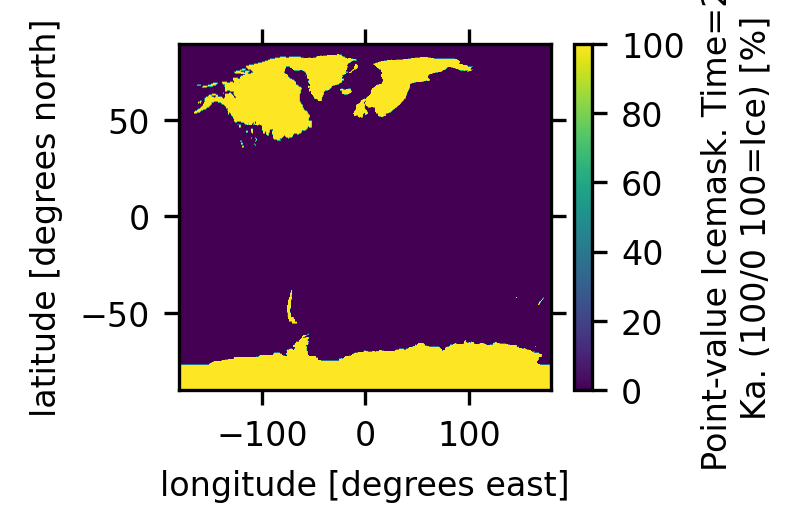

In [39]:
glc_ano_i6g_int = glc_lgm_i6g.interp(
    lat=ds_glc.LAT, lon=ds_glc.LON, method='linear',
    kwargs={"fill_value": "extrapolate"})
glc_ano_i6g_int.thin(10).plot(size=1.5)

print(f"LGM ICE-G ice sheet pct: max = {glc_ano_i6g_int.max().values}, min = {glc_ano_i6g_int.min().values}")
glc_ano_i6g_int

#### Use np.digitize to bin the LGM TOPO into elevation classes

In [40]:
lgm_elevation_class = xr.apply_ufunc(np.digitize, ds_glc_lgm.TOPO, bins_e) - 1
lgm_elevation_class = xr.where(lgm_elevation_class < 0, 0, lgm_elevation_class)
lgm_elevation_class = xr.where(lgm_elevation_class > 70, 00, lgm_elevation_class)

lgm_elevation_class
print(f"lgm_elevation_class: max = {lgm_elevation_class.max().values:5.2f}, min = {lgm_elevation_class.min().values:5.2f}")

lgm_elevation_class: max = 70.00, min =  0.00


In [41]:
# Explore np.digitize
print(bins_e)
print(len(bins_e))
print(np.digitize(50, bins_e))
print(np.digitize(100050, bins_e))

[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000. 10000.]
72
1
72


#### Assign ice sheet coverage according to the elevation class

In [42]:
lgm_pct_icesheet = ds_glc_lgm.PCT_GLC_ICESHEET * 0

lgm_pct_icesheet.loc[dict(z=lgm_elevation_class, 
                          lat=ds_glc_lgm.lat, 
                          lon=ds_glc_lgm.lon)] = glc_ano_i6g_int

#### Only update the LGM glacier coverage over ICE-6G ice region

In [43]:
dims_order = ds_glc_lgm.PCT_GLC_ICESHEET.dims

# Set the LGM ice sheet coverage as that from ICE-6G
ds_glc_lgm.PCT_GLC_ICESHEET.data = xr.where(
    glc_ano_i6g_int > 0, lgm_pct_icesheet, ds_glc_lgm.PCT_GLC_ICESHEET).transpose(*dims_order)

# Set the LGM glacier coverage as zero if ICE-6G ice exists
ds_glc_lgm.PCT_GLC_GIC.data = xr.where(
    glc_ano_i6g_int > 0, 0, ds_glc_lgm.PCT_GLC_GIC).transpose(*dims_order)

# Set PCT_GLACIER and the sum of glaciers and ice sheets over the elevation classes
ds_glc_lgm.PCT_GLACIER.data = (ds_glc_lgm.PCT_GLC_GIC + ds_glc_lgm.PCT_GLC_ICESHEET).sum('z')

# Again, I am going to allow the existence of data >100%, as they are small and inherented from the preindustrial file
print(ds_glc_lgm.PCT_GLACIER.max().values)
print(ds_glc_lgm.PCT_GLC_ICESHEET.sum('z').max().values)
print(ds_glc_lgm.PCT_GLC_GIC.sum('z').max().values)

100.00000762939453
100.0
100.00000762939453


#### Make plots to check results

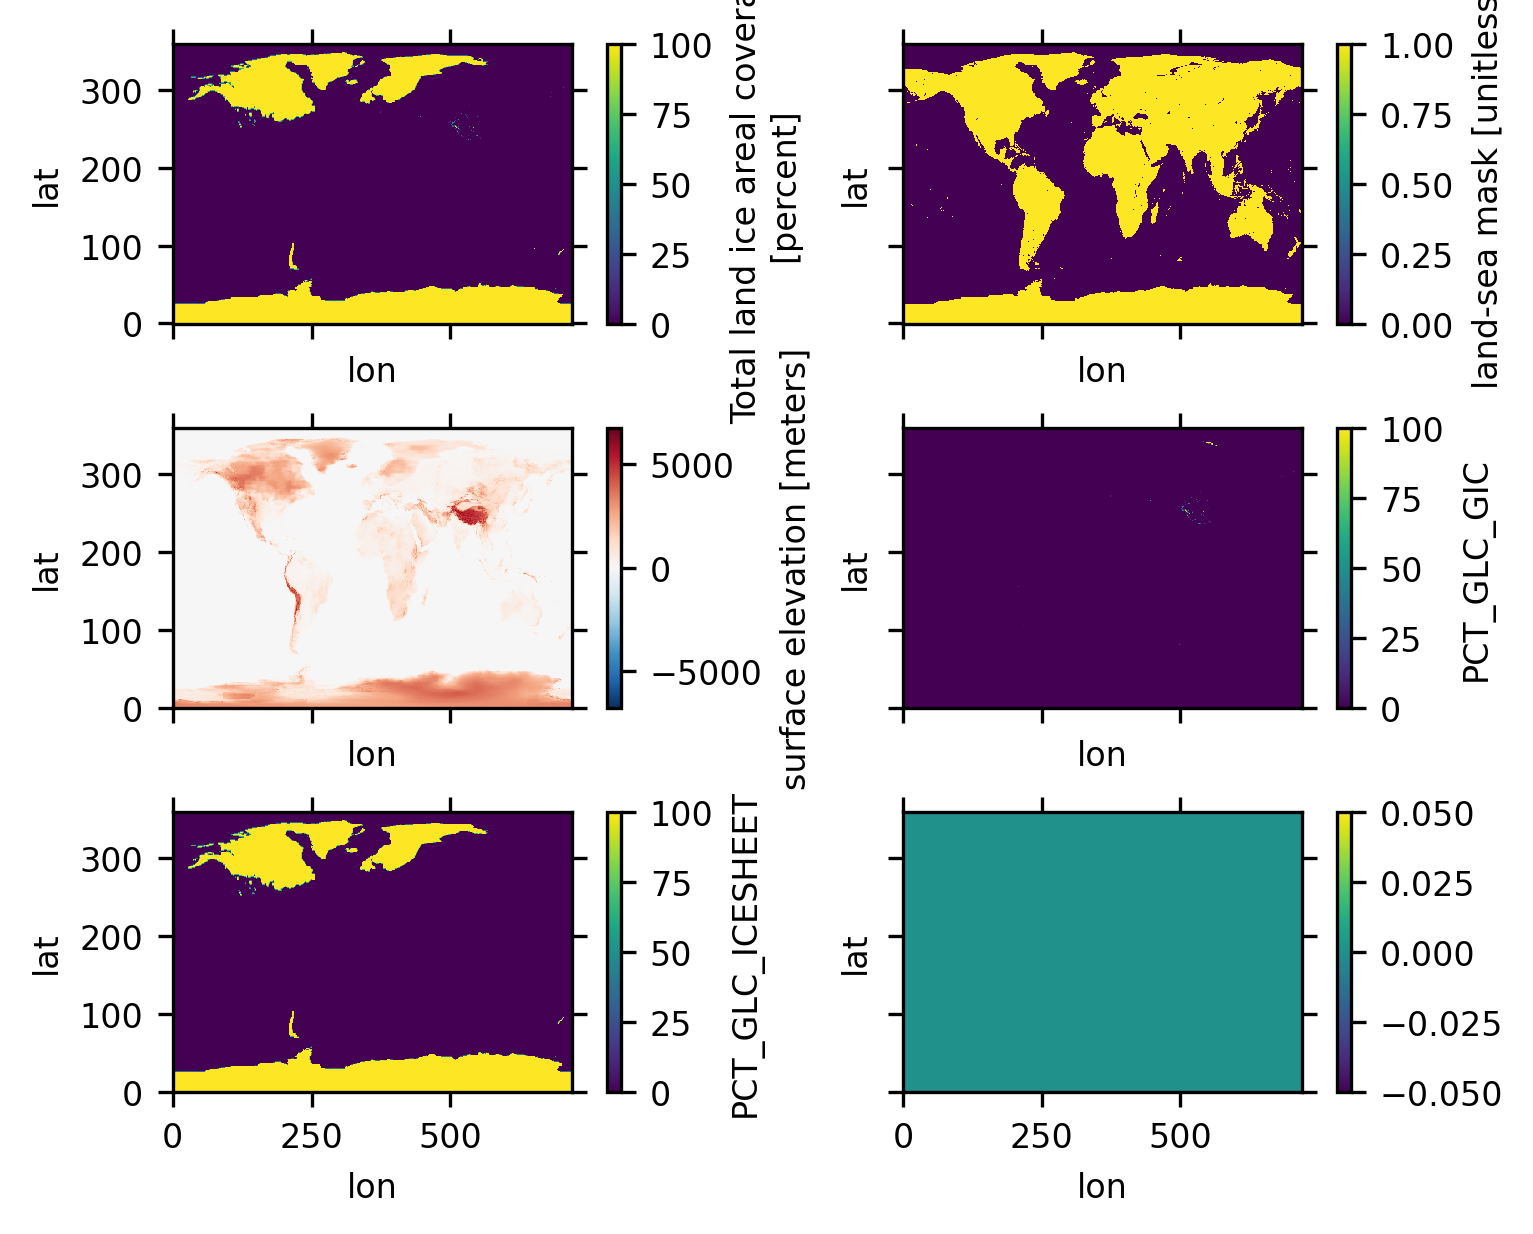

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for vname, ax in zip(
    ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET'],
    axes,
):
    var = ds_glc_lgm[vname]
    if vname == 'PCT_GLC_GIC' or vname == 'PCT_GLC_ICESHEET':
        var = ds_glc_lgm[vname].sum('z')
    var.thin(10).plot(ax=ax)

var = ds_glc_lgm['PCT_GLACIER'] - (ds_glc_lgm['PCT_GLC_GIC'] + ds_glc_lgm['PCT_GLC_ICESHEET']).sum('z')
var.thin(10).plot(ax=axes[5])

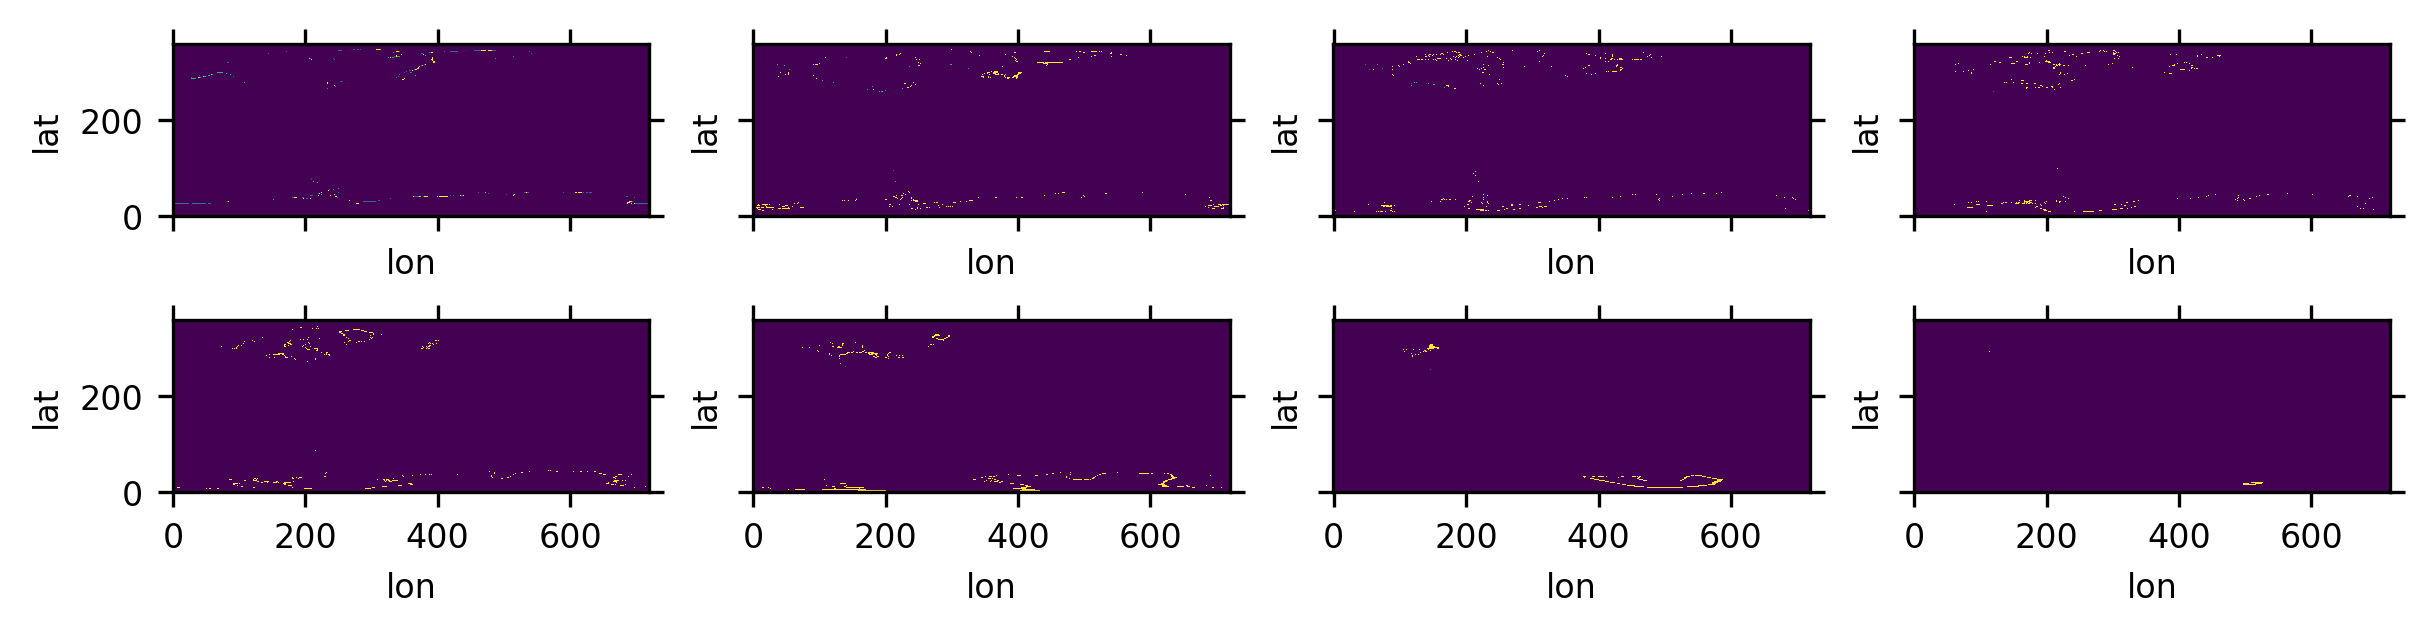

In [45]:
fig, axes = plt.subplots(2, 4, figsize=(8, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for i_elev, ax in zip(np.linspace(0, 40, 8).astype(int), axes):

    ds_glc_lgm.PCT_GLC_ICESHEET.isel(z=i_elev).thin(10).plot(
        ax=ax, add_colorbar=False)

### Take a look at a grid point over the Laurentide Ice Sheet

In [46]:
idx_lat = 3000
idx_lon = 1500

ds = ds_glc_lgm

print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)

print(bins_c[bin_idx-1])

print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

Examine point: lat = 60.03, lon = -104.97
PCT_GLACIER: 100.0
LANDMASK: 1.0
TOPO: 3496.46142578125
PCT_GLC_GIC: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PCT_GLC_ICESHEET: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
BIN_EDGES: [    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  390

### Save the LGM glacier file and update the namelist

In [47]:
ds_glc_lgm.to_netcdf(lgm_glc_file)
subprocess.run(['ncks', "-hO5", lgm_glc_file, lgm_glc_file])

lgm_nml_dict['mksurfdata_input']['mksrf_fglacier'] = lgm_glc_file
lgm_nml_dict['mksurfdata_input']['mksrf_fglacier'] = lgm_glc_file

### Update the LGM glacier region file

In [48]:
lgm_nml_dict['mksurfdata_input']['mksrf_fglacierregion'] = '/glade/work/jiangzhu/scripts/cesm2_21ka_setup/surfdata/GLACIER_REGION.nc'
lgm_nml_dict['mksurfdata_input']['mksrf_fglacierregion_mesh'] = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.9x1.25_nomask_cdf5_c200129.nc'

---
## Step 5: Write the final namelist file and run mksurfdata

In [49]:
f90nml.write(lgm_nml_dict, lgm_nml, force=True)

In [50]:
for key in lgm_nml_dict['mksurfdata_input'].keys():
    print(f"{key}: {lgm_nml_dict['mksurfdata_input'][key]}")

mksrf_fgrid_mesh: /glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc
mksrf_fgrid_mesh_nx: 48600
mksrf_fgrid_mesh_ny: 1
mksrf_flai: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_pftlaihgt_ctsm52_histLUH2_2005.c20230226_21ka_nnfilled.nc
mksrf_flai_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoicol: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_soilcolor_ctsm52_histLUH2_2005.c20230226_21ka_nnfilled.nc
mksrf_fsoicol_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoitex: /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/mksrf_soil_mapunits_5x5min_WISE.c220330_21ka_nnfilled.nc
mksrf_fsoitex_lookup: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_lookup.10level.WISE.c220330.nc
mksrf_fsoitex_mesh: /glade/campaign/cesm/cesmda

In [51]:
%%time

cmd = (
    f"{mksurfdata_exe} < {lgm_nml} "
)
print(cmd)
subprocess.run(cmd, shell=True)

/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/tool_bld/mksurfdata < /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250210.namelist 


 Attempting to initialize control settings .....


   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71CPU times: user 147 ms, sys: 1.05 s, total: 1.2 s
Wall time: 1h 22min 57s


CompletedProcess(args='/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/tool_bld/mksurfdata < /glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c250210.namelist ', returncode=0)

---
## Step 6: Update the SLOPE and STDELEV variables in the surfdata
- We skipped the mksrf_ftopostats file because I don't know how to modify it.
- I am directly updating the variables in the surface data using nearest neighbor.
- SLOPE is used in Surface Water Storage and ELEVATION is used in Snow Covered Area Fraction.
- I think it is also fine to slip this step.

In [52]:
ds_lgm_surfdata = xr.open_dataset(fsurdat_out)

# Use this file to get the land fraction, LANDFRAC_MKSURFDATA
ds_pre_surfdata = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/surfdata_ne30np4.pg3_hist_1850_78pfts_c240908.nc')

ds_lgm_surfdata

<xarray.Dataset> Size: 434MB
Dimensions:                  (gridcell: 48600, nlevsoi: 10, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10,
                              cft: 2, natpft: 15, time: 12, lsmpft: 17)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 8B 15 16
  * time                     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: gridcell, nlevsoi, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec, lsmpft
Data variables: (12/82)
    LONGXY                   (gridcell) float64 389kB ...
    LATIXY                   (gridcell) float64 389kB ...
    mxsoil_color             int32 4B ...
    SOIL_COLOR               (gridcell) int32 194kB ...
    PCT_SAND                 (nlevsoi, gridcell) float32 2MB ...
    PCT_CLAY                 (nlevsoi, gridcell) float32 2MB ...
    ...                       ...
    PCT_NAT_PFT              (natpft, gridcell) float64 6MB ...
    PCT_CFT                  (cft, gridcell) float64 778kB ...
    MONTHLY_LAI              (time, lsmpft, gridcell) float64 79MB ...
    MONTHLY_SAI              (time, lsmpft, gridcell) float64 79MB ...
    MONTHLY_HEIGHT_TOP       (time, lsmpft, gridcell) float64 79MB ...
    MONTHLY_HEIGHT_BOT       (time, lsmpft, gridcell) float64 79MB ...
Attributes: (12/47)
    Conventions:                              NCAR-CESM
    History_Log:                              created on: 02-10-25 21:21:50
    Source:                                   Community Land Model: CLM5
    Version:                                  ctsm5.2.028
    Dataset_Version:                          5.3
    Logname:                                  jiangzhu
    ...                                       ...
    lai_raw_data_file_name:                   mksrf_pftlaihgt_ctsm52_histLUH2...
    soil_color_raw_data_file_name:            mksrf_soilcolor_ctsm52_histLUH2...
    soil_texture_mapunit_raw_data_file_name:  mksrf_soil_mapunits_5x5min_WISE...
    soil_texture_lookup_raw_data_file_name:   mksrf_soil_lookup.10level.WISE....
    fmax_raw_data_file_name:                  mksrf_fmax_0.125x0.125_c200220_...
    VOC_EF_raw_data_file_name:                mksrf_vocef_0.5x0.5_simyr2000.c...

In [53]:
ds_pre_surfdata

<xarray.Dataset> Size: 2GB
Dimensions:                  (gridcell: 48600, nlevsoi: 10, numurbl: 3,
                              numrad: 2, nlevurb: 10, nglcecp1: 11, nglcec: 10,
                              cft: 64, natpft: 15, time: 12, lsmpft: 79)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 256B 15 16 17 18 19 ... 74 75 76 77 78
  * time                     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: gridcell, nlevsoi, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec, lsmpft
Data variables: (12/82)
    LONGXY                   (gridcell) float64 389kB ...
    LATIXY                   (gridcell) float64 389kB ...
    mxsoil_color             int32 4B ...
    SOIL_COLOR               (gridcell) int32 194kB ...
    PCT_SAND                 (nlevsoi, gridcell) float32 2MB ...
    PCT_CLAY                 (nlevsoi, gridcell) float32 2MB ...
    ...                       ...
    PCT_NAT_PFT              (natpft, gridcell) float64 6MB ...
    PCT_CFT                  (cft, gridcell) float64 25MB ...
    MONTHLY_LAI              (time, lsmpft, gridcell) float64 369MB ...
    MONTHLY_SAI              (time, lsmpft, gridcell) float64 369MB ...
    MONTHLY_HEIGHT_TOP       (time, lsmpft, gridcell) float64 369MB ...
    MONTHLY_HEIGHT_BOT       (time, lsmpft, gridcell) float64 369MB ...
Attributes: (12/46)
    Conventions:                              NCAR-CESM
    History_Log:                              created on: 09-08-24 19:40:15
    Source:                                   Community Land Model: CLM5
    Version:                                  branch_tags/ctsm5.3.n03_ctsm5.2...
    Dataset_Version:                          5.3
    Logname:                                  slevis
    ...                                       ...
    lai_raw_data_file_name:                   mksrf_landuse_ctsm53_pftlai_CLI...
    soil_color_raw_data_file_name:            mksrf_landuse_ctsm53_soilcolor_...
    soil_texture_mapunit_raw_data_file_name:  mksrf_soil_mapunits_5x5min_WISE...
    soil_texture_lookup_raw_data_file_name:   mksrf_soil_lookup.10level.WISE....
    fmax_raw_data_file_name:                  mksrf_fmax_0.125x0.125_c200220.nc
    VOC_EF_raw_data_file_name:                mksrf_vocef_0.5x0.5_simyr2000.c...

In [54]:
dims_order = ds_lgm_surfdata.STD_ELEV.dims
std_elev_masked = xr.where(
    ds_pre_surfdata.LANDFRAC_MKSURFDATA > 0, ds_lgm_surfdata.STD_ELEV, np.nan).transpose(*dims_order)

# There may be a better method to find nearest neighbor on the CAM-SE grid.
# For now, I am using this.
std_elev_masked_filled = fill_na(std_elev_masked, 'gridcell', 'gridcell', n_points)

ds_lgm_surfdata.STD_ELEV.data = std_elev_masked_filled * xr.where(
    ds_lgm_surfdata.LANDFRAC_MKSURFDATA > 0, 1, 0)

In [55]:
dims_order = ds_lgm_surfdata.SLOPE.dims
slope_masked = xr.where(
    ds_pre_surfdata.LANDFRAC_MKSURFDATA > 0, ds_lgm_surfdata.SLOPE, np.nan).transpose(*dims_order)

# There may be a better method to find nearest neighbor on the CAM-SE grid.
# For now, I am using this.
slope_masked_filled = fill_na(slope_masked, 'gridcell', 'gridcell', n_points)

ds_lgm_surfdata.SLOPE.data = slope_masked_filled * xr.where(
    ds_lgm_surfdata.LANDFRAC_MKSURFDATA > 0, 1, 0)

In [56]:
ds_lgm_surfdata.to_netcdf(fsurdat_out_topostats)
subprocess.run(['ncks', "-hO5", fsurdat_out_topostats, fsurdat_out_topostats])

CompletedProcess(args=['ncks', '-hO5', '/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_topostats_c250210.nc', '/glade/work/jiangzhu/github/ctsm5.3.021/tools/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_topostats_c250210.nc'], returncode=0)